In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc, log_loss
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import AdaBoostClassifier

### Set Random Seed for Reproducibility

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
# Set random seeds for reproducibility
def set_random_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# Load Data

In [ ]:
#Load data
augmented_df = pd.read_csv("/content/drive/MyDrive/DS207 Final Project/augmented_train_data.csv")
train_df = pd.read_csv("/content/drive/MyDrive/DS207 Final Project/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DS207 Final Project/test_data.csv")
val_df = pd.read_csv("/content/drive/MyDrive/DS207 Final Project/val_data.csv")

In [10]:
#Separate data into X and y
X_aug = augmented_df.drop(columns = ["DEATH_EVENT"])
y_aug = augmented_df.DEATH_EVENT

X_train = train_df.drop(columns = ["DEATH_EVENT"])
y_train = train_df.DEATH_EVENT

X_test = test_df.drop(columns = ["DEATH_EVENT"])
y_test = test_df.DEATH_EVENT

X_val = val_df.drop(columns = ["DEATH_EVENT"])
y_val = val_df.DEATH_EVENT

# Define Functions

In [11]:
def print_results(train_acc, val_acc, recall, precision, model_name="", acc_loss=[]):
    print(
        f"{model_name}\n"
        + "-" * 50
        + f"\nTrain Accuracy: {train_acc:.4f}"
        + f"\nValidation Accuracy: {val_acc:.4f}"
        + f"\nTest Accuracy: {acc_loss[1]:.4f}"
        + f"\nTest Loss: {acc_loss[0]:.4f}"
        + f"\nTest Recall: {recall:.4f}"
        + f"\nTest Precision: {precision:.4f}"
    )

    return [train_acc, val_acc, acc_loss[1], acc_loss[0], recall, precision]

# Models

## Baseline Model

In [12]:
#Define baseline model
def baseline_model(X = []):
  pred = np.zeros(shape = X.shape[0])
  return pred

#Define binary crossentropy
def binary_crossentropy(actuals,predictions):
  sum = 0
  for i, pred in enumerate(predictions):
    sum += actuals.iloc[i]*np.log(np.where(pred == 0, 1e-16, pred)) + (1 - actuals.iloc[i])*np.log(1 - pred)
  return -sum/ predictions.shape[0]

In [13]:
#Calculate train and validation accuracy
train_baseline_pred = baseline_model(X_train)
val_baseline_pred = baseline_model(X_val)
test_baseline_pred = baseline_model(X_test)

train_accuracy = accuracy_score(y_train, train_baseline_pred)
val_accuracy = accuracy_score(y_val, val_baseline_pred)
test_accuracy = accuracy_score(y_test, test_baseline_pred)
test_recall = recall_score(y_test,test_baseline_pred)
test_precision = precision_score(y_test, test_baseline_pred)
print(f"Baseline Train Accuracy: {train_accuracy:.4f}\nBaseline Val Accuracy: {val_accuracy:.4f}\nBaseline Test Accuracy: {test_accuracy:.4f}")

Baseline Train Accuracy: 0.6760
Baseline Val Accuracy: 0.6333
Baseline Test Accuracy: 0.7333


c:\Users\kentb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
train_loss = binary_crossentropy(y_train, train_baseline_pred)
val_loss = binary_crossentropy(y_val, val_baseline_pred)
test_loss = binary_crossentropy(y_test, test_baseline_pred)
print(f"Baseline Train Loss: {train_loss:.4f}\nBaseline Val Loss: {val_loss:.4f}\nBaseline Test Loss: {test_loss:.4f}")

Baseline Train Loss: 11.9374
Baseline Val Loss: 13.5085
Baseline Test Loss: 9.8244


In [15]:
#Collect results
baseline_results = [train_accuracy, val_accuracy, test_accuracy, test_loss ,test_recall, test_precision]

Text(0.5, 1.0, 'Baseline Test Confusion Matrix')

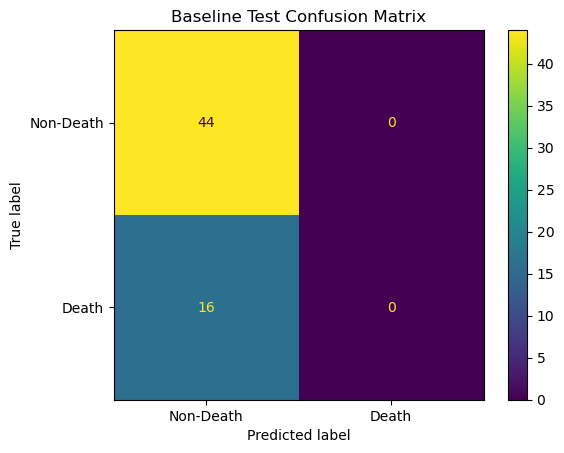

In [16]:
#Plot confusion matrix
cm = confusion_matrix(y_test, test_baseline_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Baseline Test Confusion Matrix")

## Logistic Regression

In [17]:
#Define model
def build_lr(num_units, learning_rate):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = num_units,
      use_bias = True
  ))

  model.add(tf.keras.layers.Dense(
      units = 1,
      activation = 'sigmoid'
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

### Non-Augmented

In [18]:
set_random_seed(42)

# Fit and run model
lr_model = build_lr(X_train.shape[1], learning_rate = 0.01)
lr_model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs = 50, batch_size= 30, verbose=0)
lr_results = lr_model.evaluate(X_test, y_test, verbose = 0)


#Define model predictions
lr_train_pred = (lr_model.predict(X_train, verbose = 0) > 0.5).astype(int).flatten()
lr_val_pred = (lr_model.predict(X_val, verbose = 0) > 0.5).astype(int).flatten()
lr_test_pred = lr_model.predict(X_test, verbose = 0)
lr_test_pred = np.array([1 if i > .5 else 0 for i in lr_test_pred])
lr_precision = precision_score(y_test, lr_test_pred)
lr_recall = recall_score(y_test, lr_test_pred)
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_val_acc = accuracy_score(y_val, lr_val_pred)

#Print results
lr_results = print_results(lr_train_acc, lr_val_acc, lr_recall, lr_precision,model_name = "Logistic Regression", acc_loss = lr_results)

Logistic Regression
--------------------------------------------------
Train Accuracy: 0.8380
Validation Accuracy: 0.8000
Test Accuracy: 0.8167
Test Loss: 0.3660
Test Recall: 0.5625
Test Precision: 0.6923


Text(0.5, 1.0, 'Logistic Regression Test Confusion Matrix')

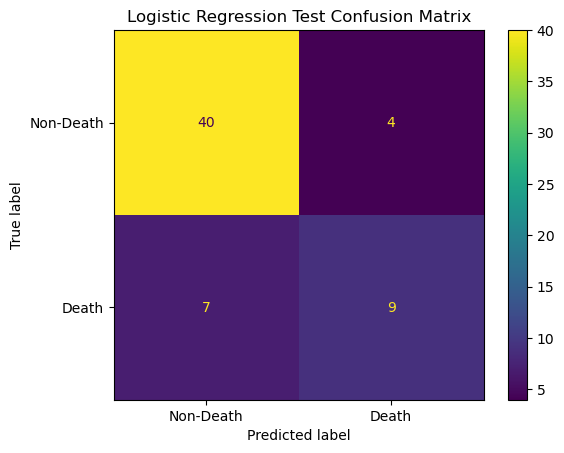

In [19]:
#Plot confusion matrix
cm = confusion_matrix(y_test, lr_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Logistic Regression Test Confusion Matrix")

### Augmented

In [20]:
set_random_seed(55)

# Fit and run model
aug_lr_model = build_lr(X_aug.shape[1], learning_rate = 0.01)
aug_lr_model.fit(X_aug, y_aug, validation_data= (X_val, y_val), epochs = 50, batch_size= 30, verbose=0)
aug_lr_results = aug_lr_model.evaluate(X_test, y_test, verbose = 0)

#Define model predictions
aug_lr_train_pred = (aug_lr_model.predict(X_aug, verbose = 0) > 0.5).astype(int).flatten()
aug_lr_val_pred = (aug_lr_model.predict(X_val, verbose = 0) > 0.5).astype(int).flatten()
aug_lr_test_pred = aug_lr_model.predict(X_test, verbose = 0)
aug_lr_test_pred = np.array([1 if i > .5 else 0 for i in aug_lr_test_pred])
aug_lr_precision = precision_score(y_test, aug_lr_test_pred)
aug_lr_recall = recall_score(y_test, aug_lr_test_pred)
aug_lr_train_acc = accuracy_score(y_aug, aug_lr_train_pred)
aug_lr_val_acc = accuracy_score(y_val, aug_lr_val_pred)

#Print results
aug_lr_results = print_results(aug_lr_train_acc, aug_lr_val_acc, aug_lr_recall, aug_lr_precision,model_name = "Augmented Logistic Regression", acc_loss = aug_lr_results)

Augmented Logistic Regression
--------------------------------------------------
Train Accuracy: 0.7687
Validation Accuracy: 0.8333
Test Accuracy: 0.8667
Test Loss: 0.3333
Test Recall: 0.6250
Test Precision: 0.8333


Text(0.5, 1.0, 'Augmented Logistic Regression Test Confusion Matrix')

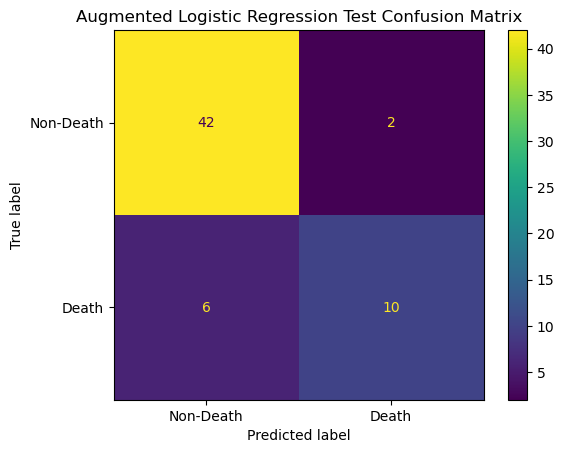

In [21]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_lr_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Logistic Regression Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

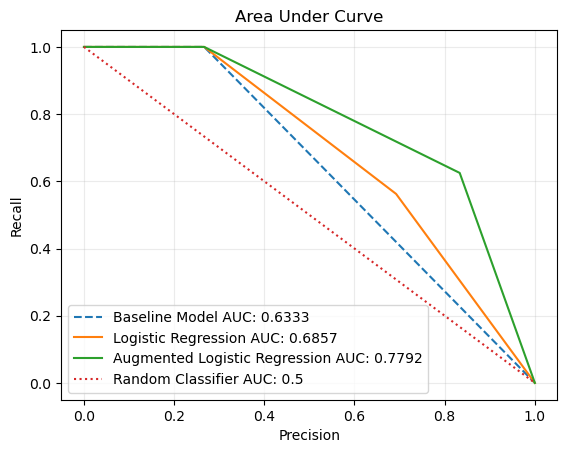

In [22]:
#Calculate precisions and recalls
aug_lr_precisions, aug_lr_recalls, thresholds = precision_recall_curve(y_test, aug_lr_test_pred)
lr_precisions, lr_recalls, thresholds = precision_recall_curve(y_test, lr_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

lr_precisions= np.insert(lr_precisions, 0,0)
lr_recalls = np.insert(lr_recalls, 0,1)

aug_lr_precisions= np.insert(aug_lr_precisions, 0,0)
aug_lr_recalls = np.insert(aug_lr_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(lr_precisions, lr_recalls, label = f"Logistic Regression AUC: {round(auc(lr_recalls, lr_precisions), 4)}")
plt.plot(aug_lr_precisions, aug_lr_recalls, label = f"Augmented Logistic Regression AUC: {round(auc(aug_lr_recalls, aug_lr_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Sequential Neural Networks

In [23]:
def ANN_build(num_units, learning_rate, hidden_layers = []):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = num_units,
      use_bias = True
  ))

  for neurons in hidden_layers:
    model.add(
        tf.keras.layers.Dense(
            units = neurons,
            activation = 'relu'
        )
    )

  model.add(tf.keras.layers.Dense(
      units = 1,
      activation = 'sigmoid'
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

### Non-Augmented

In [24]:
set_random_seed(78)

# Fit and run model
ann_model = ANN_build(X_train.shape[1], 0.01, [16,4])
ann_model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs = 80, batch_size= 256, verbose = 0)
ann_results = ann_model.evaluate(X_test, y_test, verbose = 0)

#Define model predictions
ann_train_pred = (ann_model.predict(X_train, verbose = 0) > 0.5).astype(int).flatten()
ann_val_pred = (ann_model.predict(X_val, verbose = 0) > 0.5).astype(int).flatten()
ann_test_pred = ann_model.predict(X_test, verbose = 0)
ann_test_pred = np.array([1 if i > .5 else 0 for i in ann_test_pred])
ann_precision = precision_score(y_test, ann_test_pred)
ann_recall = recall_score(y_test, ann_test_pred)
ann_train_acc = accuracy_score(y_train, ann_train_pred)
ann_val_acc = accuracy_score(y_val, ann_val_pred)

#Print results
ann_results = print_results(ann_train_acc, ann_val_acc , ann_recall, ann_precision,model_name = "Artificial Neural Network", acc_loss = ann_results)

Artificial Neural Network
--------------------------------------------------
Train Accuracy: 0.9777
Validation Accuracy: 0.8167
Test Accuracy: 0.7833
Test Loss: 1.0337
Test Recall: 0.6250
Test Precision: 0.5882


Text(0.5, 1.0, 'Neural Network Test Confusion Matrix')

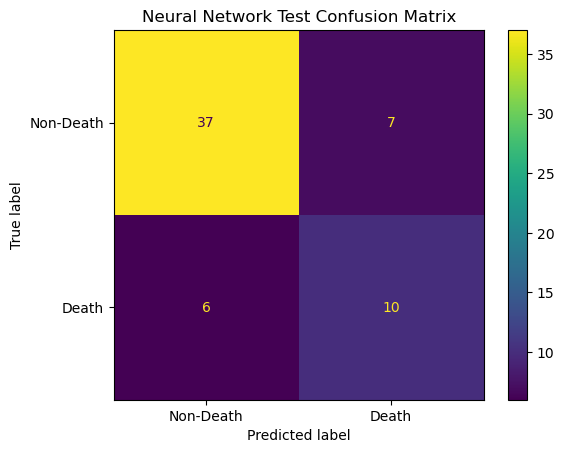

In [25]:
#Plot confusion matrix
cm = confusion_matrix(y_test, ann_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Neural Network Test Confusion Matrix")

### Augmented

In [26]:
set_random_seed(15)

# Fit and run model
aug_ann_model = ANN_build(X_aug.shape[1], 0.01, [16,4])
aug_ann_model.fit(X_aug, y_aug, validation_data= (X_val, y_val), epochs = 80, batch_size= 256, verbose = 0)
aug_ann_results = aug_ann_model.evaluate(X_test, y_test, verbose = 0)

#Define model predictions
aug_ann_train_pred = (aug_ann_model.predict(X_aug, verbose = 0) > 0.5).astype(int).flatten()
aug_ann_val_pred = (aug_ann_model.predict(X_val, verbose = 0) > 0.5).astype(int).flatten()
aug_ann_test_pred = aug_ann_model.predict(X_test, verbose = 0)
aug_ann_test_pred = np.array([1 if i > .5 else 0 for i in aug_ann_test_pred])
aug_ann_precision = precision_score(y_test, aug_ann_test_pred)
aug_ann_recall = recall_score(y_test, aug_ann_test_pred)
aug_ann_train_acc = accuracy_score(y_aug, aug_ann_train_pred)
aug_ann_val_acc = accuracy_score(y_val, aug_ann_val_pred)

#Print results
aug_ann_results = print_results(aug_ann_train_acc, aug_ann_val_acc , aug_ann_recall, aug_ann_precision,model_name = "Augmented Artificial Neural Network", acc_loss = aug_ann_results)

Augmented Artificial Neural Network
--------------------------------------------------
Train Accuracy: 0.8098
Validation Accuracy: 0.8667
Test Accuracy: 0.8500
Test Loss: 0.3565
Test Recall: 0.5000
Test Precision: 0.8889


Text(0.5, 1.0, 'Augmented Neural Network Test Confusion Matrix')

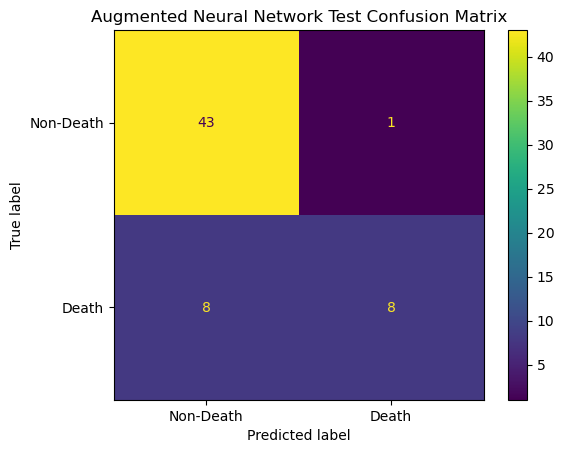

In [27]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_ann_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Neural Network Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

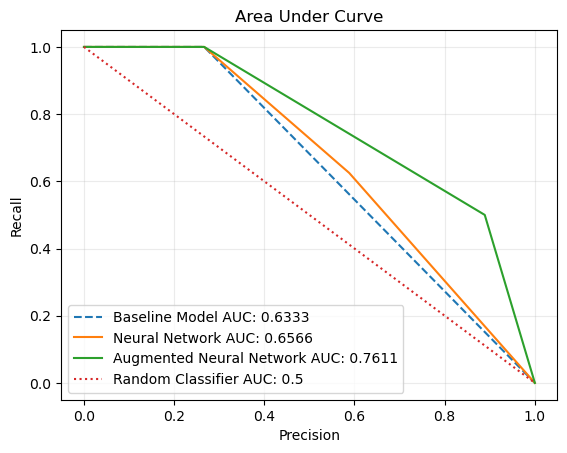

In [28]:
#Calculate precisions and recalls
aug_ann_precisions, aug_ann_recalls, thresholds = precision_recall_curve(y_test, aug_ann_test_pred)
ann_precisions, ann_recalls, thresholds = precision_recall_curve(y_test, ann_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

ann_precisions= np.insert(ann_precisions, 0,0)
ann_recalls = np.insert(ann_recalls, 0,1)

aug_ann_precisions= np.insert(aug_ann_precisions, 0,0)
aug_ann_recalls = np.insert(aug_ann_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(ann_precisions, ann_recalls, label = f"Neural Network AUC: {round(auc(ann_recalls, ann_precisions), 4)}")
plt.plot(aug_ann_precisions, aug_ann_recalls, label = f"Augmented Neural Network AUC: {round(auc(aug_ann_recalls, aug_ann_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Decision Tree

### Non-Augmented

In [29]:
set_random_seed(18)

#Build a Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=1234)

# Train the model on the training set
dt_model.fit(X_train, y_train)

#Define model predictions
dt_train_pred = (dt_model.predict(X_train) > 0.5).astype(int).flatten()
dt_val_pred = (dt_model.predict(X_val) > 0.5).astype(int).flatten()
dt_test_pred = dt_model.predict(X_test)
dt_results = [log_loss(y_test, dt_model.predict_proba(X_test)), accuracy_score(y_test,dt_test_pred)]
dt_precision = precision_score(y_test, dt_test_pred)
dt_recall = recall_score(y_test, dt_test_pred)
dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_val_acc = accuracy_score(y_val, dt_val_pred)

#Print results
dt_results = print_results(dt_train_acc, dt_val_acc , dt_recall, dt_precision,model_name = "Decision Tree", acc_loss = dt_results)


Decision Tree
--------------------------------------------------
Train Accuracy: 0.9441
Validation Accuracy: 0.8167
Test Accuracy: 0.7833
Test Loss: 6.6711
Test Recall: 0.5625
Test Precision: 0.6000


Text(0.5, 1.0, 'Decision Tree Test Confusion Matrix')

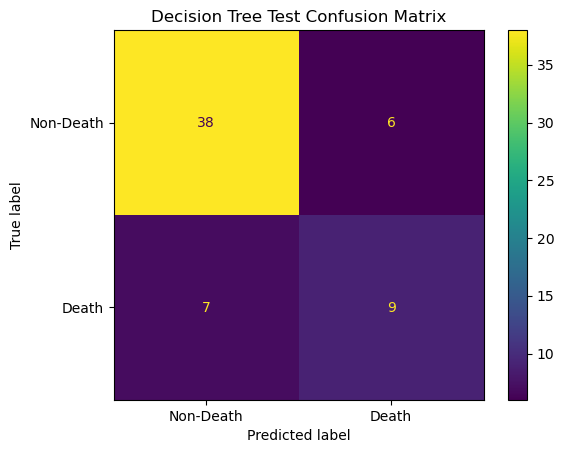

In [30]:
#Plot confusion matrix
cm = confusion_matrix(y_test, dt_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Decision Tree Test Confusion Matrix")

### Augmented

In [31]:
set_random_seed(38)

#Build a Decision Tree model
aug_dt_model = DecisionTreeClassifier(max_depth=5, random_state=1234)

# Train the model on the training set
aug_dt_model.fit(X_aug, y_aug)

#Define model predictions
aug_dt_train_pred = (aug_dt_model.predict(X_aug) > 0.5).astype(int).flatten()
aug_dt_val_pred = (aug_dt_model.predict(X_val) > 0.5).astype(int).flatten()
aug_dt_test_pred = aug_dt_model.predict(X_test)
aug_dt_results = [log_loss(y_test, aug_dt_model.predict_proba(X_test)), accuracy_score(y_test,aug_dt_test_pred)]
aug_dt_precision = precision_score(y_test, aug_dt_test_pred)
aug_dt_recall = recall_score(y_test, aug_dt_test_pred)
aug_dt_train_acc = accuracy_score(y_aug, aug_dt_train_pred)
aug_dt_val_acc = accuracy_score(y_val, aug_dt_val_pred)

#Print results
aug_dt_results = print_results(aug_dt_train_acc, aug_dt_val_acc , aug_dt_recall, aug_dt_precision,model_name = "Decision Tree", acc_loss = aug_dt_results)

aug_dt_train_loss = log_loss(y_aug, aug_dt_model.predict_proba(X_aug))
aug_dt_val_loss = log_loss(y_val, aug_dt_model.predict_proba(X_val))
print(f"Training Loss: {aug_dt_train_loss:.4f}")
print(f"Validation Loss: {aug_dt_val_loss:.4f}")

Decision Tree
--------------------------------------------------
Train Accuracy: 0.7783
Validation Accuracy: 0.7833
Test Accuracy: 0.8000
Test Loss: 0.3357
Test Recall: 0.4375
Test Precision: 0.7000
Training Loss: 0.4677
Validation Loss: 0.4098


Text(0.5, 1.0, 'Augmented Decision Tree Test Confusion Matrix')

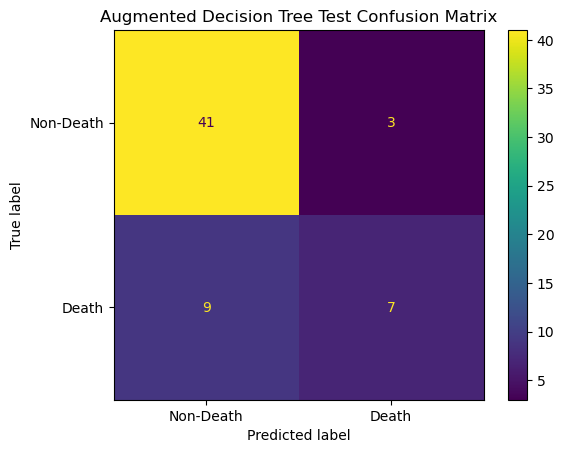

In [32]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_dt_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Decision Tree Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

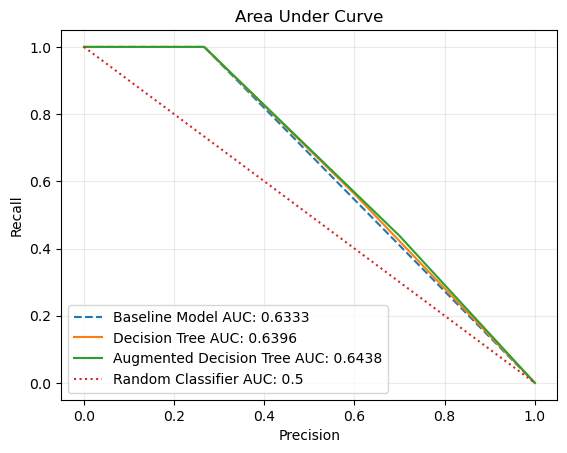

In [33]:
#Calculate precisions and recalls
aug_dt_precisions, aug_dt_recalls, thresholds = precision_recall_curve(y_test, aug_dt_test_pred)
dt_precisions, dt_recalls, thresholds = precision_recall_curve(y_test, dt_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

dt_precisions= np.insert(dt_precisions, 0,0)
dt_recalls = np.insert(dt_recalls, 0,1)

aug_dt_precisions= np.insert(aug_dt_precisions, 0,0)
aug_dt_recalls = np.insert(aug_dt_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(dt_precisions, dt_recalls, label = f"Decision Tree AUC: {round(auc(dt_recalls, dt_precisions), 4)}")
plt.plot(aug_dt_precisions, aug_dt_recalls, label = f"Augmented Decision Tree AUC: {round(auc(aug_dt_recalls, aug_dt_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Random Forest Model

### Non-Augmented

In [34]:
set_random_seed(47)

#Build a Random Forest model
rf_model = RandomForestClassifier(max_depth=5, n_estimators=100,random_state=1234)

# Train the model on the training set
rf_model.fit(X_train, y_train)

#Define model predictions
rf_train_pred = (rf_model.predict(X_train) > 0.5).astype(int).flatten()
rf_val_pred = (rf_model.predict(X_val) > 0.5).astype(int).flatten()
rf_test_pred = rf_model.predict(X_test)
rf_results = [log_loss(y_test, rf_model.predict_proba(X_test)), accuracy_score(y_test,rf_test_pred)]
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

#Print results
rf_results = print_results(rf_train_acc, rf_val_acc , rf_recall, rf_precision,model_name = "Random Forest", acc_loss = rf_results)

Random Forest
--------------------------------------------------
Train Accuracy: 0.9609
Validation Accuracy: 0.8667
Test Accuracy: 0.8667
Test Loss: 0.3408
Test Recall: 0.6875
Test Precision: 0.7857


Text(0.5, 1.0, 'Random Forest Test Confusion Matrix')

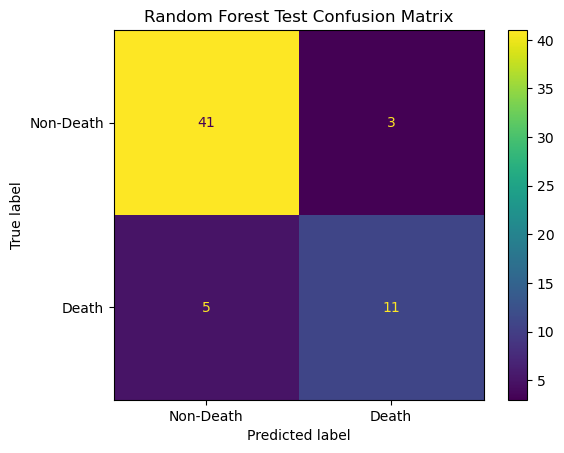

In [35]:
#Plot confusion matrix
cm = confusion_matrix(y_test, rf_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Random Forest Test Confusion Matrix")

### Augmented

In [36]:
set_random_seed(51)

#Build a Random Forest model
aug_rf_model = RandomForestClassifier(max_depth=5, n_estimators=100,random_state=1234)

# Train the model on the training set
aug_rf_model.fit(X_aug, y_aug)

#Define model predictions
aug_rf_train_pred = (aug_rf_model.predict(X_aug) > 0.5).astype(int).flatten()
aug_rf_val_pred = (aug_rf_model.predict(X_val) > 0.5).astype(int).flatten()
aug_rf_test_pred = aug_rf_model.predict(X_test)
aug_rf_results = [log_loss(y_test, aug_rf_model.predict_proba(X_test)), accuracy_score(y_test, aug_rf_test_pred)]
aug_rf_precision = precision_score(y_test, aug_rf_test_pred)
aug_rf_recall = recall_score(y_test, aug_rf_test_pred)
aug_rf_train_acc = accuracy_score(y_aug, aug_rf_train_pred)
aug_rf_val_acc = accuracy_score(y_val, aug_rf_val_pred)

#Print results
aug_rf_results = print_results(aug_rf_train_acc, aug_rf_val_acc , aug_rf_recall, aug_rf_precision,model_name = "Random Forest", acc_loss = aug_rf_results)

Random Forest
--------------------------------------------------
Train Accuracy: 0.7940
Validation Accuracy: 0.8500
Test Accuracy: 0.8167
Test Loss: 0.3918
Test Recall: 0.4375
Test Precision: 0.7778


Text(0.5, 1.0, 'Augmented Random Forest Test Confusion Matrix')

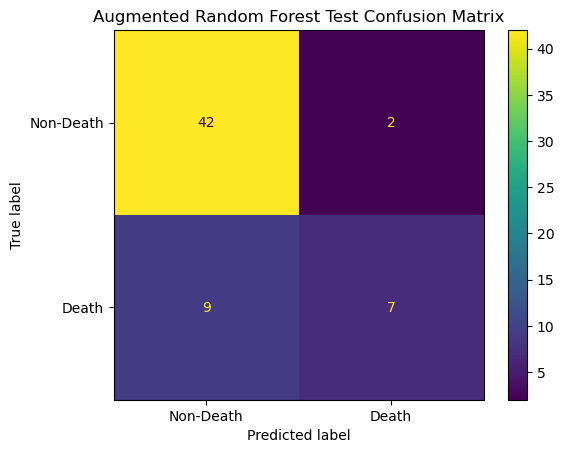

In [37]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_rf_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Random Forest Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

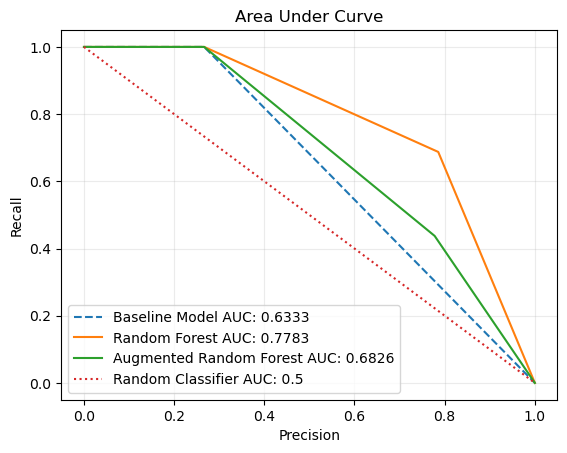

In [38]:
#Calculate precisions and recalls
aug_rf_precisions, aug_rf_recalls, thresholds = precision_recall_curve(y_test, aug_rf_test_pred)
rf_precisions, rf_recalls, thresholds = precision_recall_curve(y_test, rf_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

rf_precisions= np.insert(rf_precisions, 0,0)
rf_recalls = np.insert(rf_recalls, 0,1)

aug_rf_precisions= np.insert(aug_rf_precisions, 0,0)
aug_rf_recalls = np.insert(aug_rf_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(rf_precisions, rf_recalls, label = f"Random Forest AUC: {round(auc(rf_recalls, rf_precisions), 4)}")
plt.plot(aug_rf_precisions, aug_rf_recalls, label = f"Augmented Random Forest AUC: {round(auc(aug_rf_recalls, aug_rf_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Gradient Boosting

### Non-Augmented

In [39]:
set_random_seed(64)

# Build and evaluate the Gradient Boosting model
gb_model = GradientBoostingClassifier(max_depth = 4, n_estimators=200,random_state=1234)
gb_model.fit(X_train, y_train)

#Define model predictions
gb_train_pred = (gb_model.predict(X_train) > 0.5).astype(int).flatten()
gb_val_pred = (gb_model.predict(X_val) > 0.5).astype(int).flatten()
gb_test_pred = gb_model.predict(X_test)
gb_results = [log_loss(y_test, gb_model.predict_proba(X_test)), accuracy_score(y_test,gb_test_pred)]
gb_precision = precision_score(y_test, gb_test_pred)
gb_recall = recall_score(y_test, gb_test_pred)
gb_train_acc = accuracy_score(y_train, gb_train_pred)
gb_val_acc = accuracy_score(y_val, gb_val_pred)

#Print results
gb_results = print_results(gb_train_acc, gb_val_acc, gb_recall, gb_precision,model_name = "Gradient Boosting", acc_loss = gb_results)

Gradient Boosting
--------------------------------------------------
Train Accuracy: 1.0000
Validation Accuracy: 0.8500
Test Accuracy: 0.8167
Test Loss: 0.5466
Test Recall: 0.5625
Test Precision: 0.6923


Text(0.5, 1.0, 'Gradient Boosting Test Confusion Matrix')

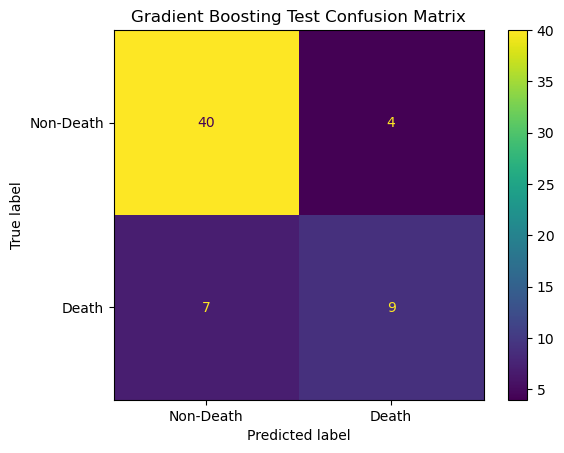

In [40]:
#Plot confusion matrix
cm = confusion_matrix(y_test, gb_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Gradient Boosting Test Confusion Matrix")

### Augmented

In [41]:
set_random_seed(104)

# Build and evaluate the Gradient Boosting model
aug_gb_model = GradientBoostingClassifier(max_depth = 4, n_estimators=200,random_state=1234)
aug_gb_model.fit(X_aug, y_aug)

#Define model predictions
aug_gb_train_pred = (aug_gb_model.predict(X_aug) > 0.5).astype(int).flatten()
aug_gb_val_pred = (aug_gb_model.predict(X_val) > 0.5).astype(int).flatten()
aug_gb_test_pred = aug_gb_model.predict(X_test)
aug_gb_results = [log_loss(y_test, aug_gb_model.predict_proba(X_test)), accuracy_score(y_test,aug_gb_test_pred)]
aug_gb_precision = precision_score(y_test, aug_gb_test_pred)
aug_gb_recall = recall_score(y_test, aug_gb_test_pred)
aug_gb_train_acc = accuracy_score(y_aug, aug_gb_train_pred)
aug_gb_val_acc = accuracy_score(y_val, aug_gb_val_pred)

#Print results
aug_gb_results = print_results(aug_gb_train_acc, aug_gb_val_acc, aug_gb_recall, aug_gb_precision,model_name = "Gradient Boosting", acc_loss = aug_gb_results)
aug_gb_train_loss = log_loss(y_aug, aug_gb_model.predict_proba(X_aug))
aug_gb_val_loss = log_loss(y_val, aug_gb_model.predict_proba(X_val))
print(f"Training Loss: {aug_gb_train_loss:.4f}")
print(f"Validation Loss: {aug_gb_val_loss:.4f}")

Gradient Boosting
--------------------------------------------------
Train Accuracy: 0.8836
Validation Accuracy: 0.8833
Test Accuracy: 0.8500
Test Loss: 0.2743
Test Recall: 0.6250
Test Precision: 0.7692
Training Loss: 0.3068
Validation Loss: 0.2920


Text(0.5, 1.0, 'Augmented Gradient Boosting Test Confusion Matrix')

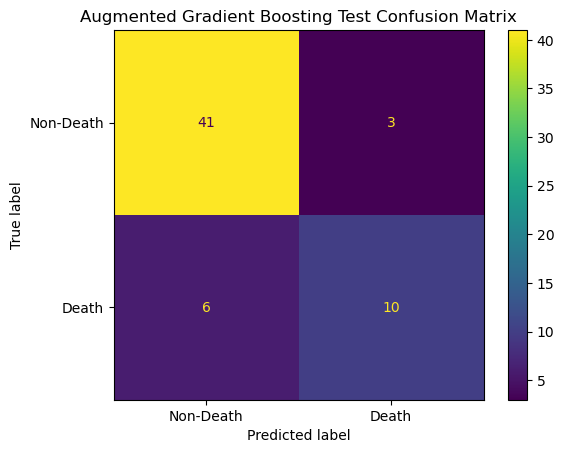

In [42]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_gb_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Gradient Boosting Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

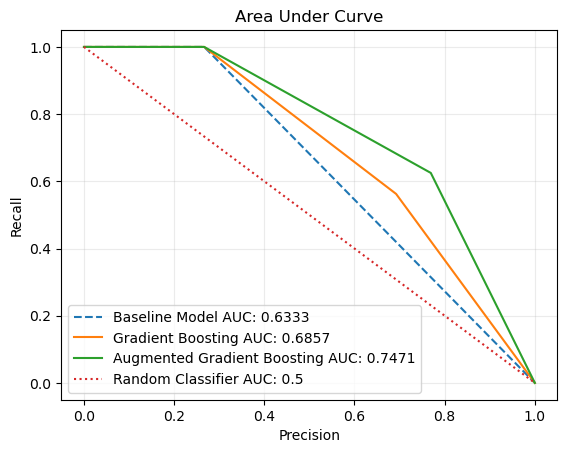

In [43]:
#Calculate precisions and recalls
aug_gb_precisions, aug_gb_recalls, thresholds = precision_recall_curve(y_test, aug_gb_test_pred)
gb_precisions, gb_recalls, thresholds = precision_recall_curve(y_test, gb_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

gb_precisions= np.insert(gb_precisions, 0,0)
gb_recalls = np.insert(gb_recalls, 0,1)

aug_gb_precisions= np.insert(aug_gb_precisions, 0,0)
aug_gb_recalls = np.insert(aug_gb_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(gb_precisions, gb_recalls, label = f"Gradient Boosting AUC: {round(auc(gb_recalls, gb_precisions), 4)}")
plt.plot(aug_gb_precisions, aug_gb_recalls, label = f"Augmented Gradient Boosting AUC: {round(auc(aug_gb_recalls, aug_gb_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Adaptive Boosting (AdaBoost)

### Non-Augmented

In [44]:
set_random_seed(107)

# Build and evaluate the Adaptive Boosting (AdaBoost) model
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada_model = AdaBoostClassifier(estimator=tree, n_estimators=400, learning_rate=0.01, random_state=77)
ada_model.fit(X_train, y_train)

#Define model predictions
ada_train_pred = (ada_model.predict(X_train) > 0.5).astype(int).flatten()
ada_val_pred = (ada_model.predict(X_val) > 0.5).astype(int).flatten()
ada_test_pred = ada_model.predict(X_test)
ada_results = [log_loss(y_test, ada_model.predict_proba(X_test)), accuracy_score(y_test,ada_test_pred)]
ada_precision = precision_score(y_test, ada_test_pred)
ada_recall = recall_score(y_test, ada_test_pred)
ada_train_acc = accuracy_score(y_train, ada_train_pred)
ada_val_acc = accuracy_score(y_val, ada_val_pred)

#Print results
ada_results = print_results(ada_train_acc, ada_val_acc, ada_recall, ada_precision,model_name = "Adaptive Boosting (AdaBoost)", acc_loss = ada_results)

Adaptive Boosting (AdaBoost)
--------------------------------------------------
Train Accuracy: 0.8659
Validation Accuracy: 0.8500
Test Accuracy: 0.8500
Test Loss: 0.5208
Test Recall: 0.6875
Test Precision: 0.7333


Text(0.5, 1.0, 'Adaptive Boosting (AdaBoost) Test Confusion Matrix')

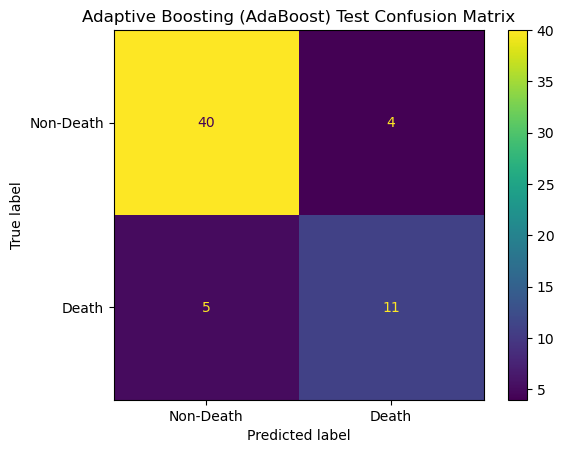

In [45]:
#Plot confusion matrix
cm = confusion_matrix(y_test, ada_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Adaptive Boosting (AdaBoost) Test Confusion Matrix")

### Augmented

In [46]:
set_random_seed(207)

# Build and evaluate the Adaptive Boosting (AdaBoost) model
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
aug_ada_model = AdaBoostClassifier(estimator=tree, n_estimators=1000, learning_rate=0.015, random_state=85)
aug_ada_model.fit(X_aug, y_aug)

#Define model predictions
aug_ada_train_pred = (aug_ada_model.predict(X_aug) > 0.5).astype(int).flatten()
aug_ada_val_pred = (aug_ada_model.predict(X_val) > 0.5).astype(int).flatten()
aug_ada_test_pred = aug_ada_model.predict(X_test)
aug_ada_results = [log_loss(y_test, aug_ada_model.predict_proba(X_test)), accuracy_score(y_test,aug_ada_test_pred)]
aug_ada_precision = precision_score(y_test, aug_ada_test_pred)
aug_ada_recall = recall_score(y_test, aug_ada_test_pred)
aug_ada_train_acc = accuracy_score(y_aug, aug_ada_train_pred)
aug_ada_val_acc = accuracy_score(y_val, aug_ada_val_pred)

#Print results
aug_ada_results = print_results(aug_ada_train_acc, aug_ada_val_acc, aug_ada_recall, aug_ada_precision,model_name = "Adaptive Boosting (AdaBoost)", acc_loss = aug_ada_results)

Adaptive Boosting (AdaBoost)
--------------------------------------------------
Train Accuracy: 0.8633
Validation Accuracy: 0.8667
Test Accuracy: 0.8333
Test Loss: 0.6103
Test Recall: 0.5000
Test Precision: 0.8000


Text(0.5, 1.0, 'Augmented Adaptive Boosting (AdaBoost) Test Confusion Matrix')

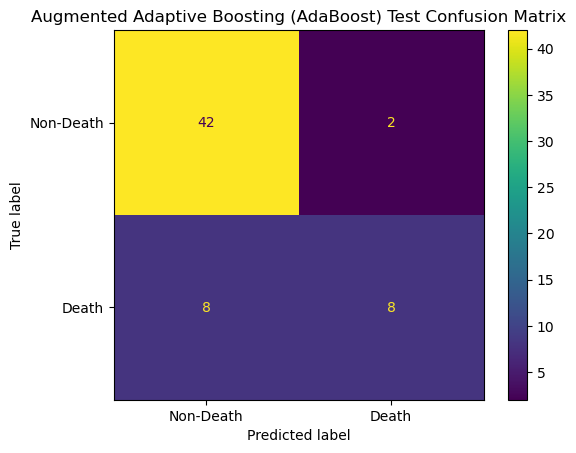

In [47]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_ada_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Adaptive Boosting (AdaBoost) Test Confusion Matrix")

### Comparison AUC

Text(0, 0.5, 'Recall')

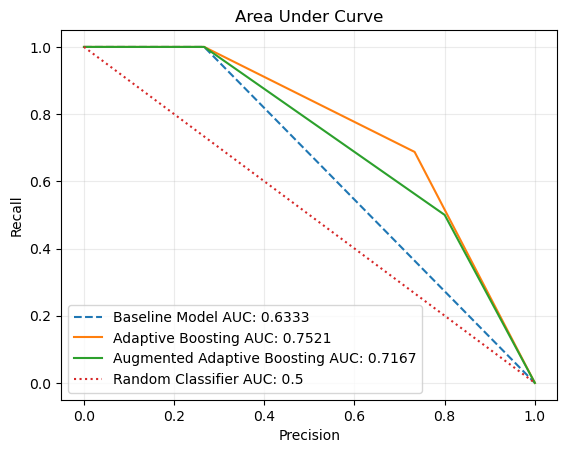

In [48]:
#Calculate precisions and recalls
aug_ada_precisions, aug_ada_recalls, thresholds = precision_recall_curve(y_test, aug_ada_test_pred)
ada_precisions, ada_recalls, thresholds = precision_recall_curve(y_test, ada_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

ada_precisions= np.insert(ada_precisions, 0,0)
ada_recalls = np.insert(ada_recalls, 0,1)

aug_ada_precisions= np.insert(aug_ada_precisions, 0,0)
aug_ada_recalls = np.insert(aug_ada_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(ada_precisions, ada_recalls, label = f"Adaptive Boosting AUC: {round(auc(ada_recalls, ada_precisions), 4)}")
plt.plot(aug_ada_precisions, aug_ada_recalls, label = f"Augmented Adaptive Boosting AUC: {round(auc(aug_ada_recalls, aug_ada_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Functional API

### Data Exploration

In [49]:
# Explore data to determine buckets for embeddings
# Combine all data
all_data = pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True)

features = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]

# Compute statistics
stats = {}
for col in features:
    stats[col] = {
        'min': all_data[col].min(),
        'max': all_data[col].max(),
        'mean': all_data[col].mean(),
        'median': all_data[col].median(),
        'lower_quantile (25%)': all_data[col].quantile(0.25),
        'upper_quantile (75%)': all_data[col].quantile(0.75)
    }


stats_df = pd.DataFrame(stats).T
stats_df

,min,max,mean,median,lower_quantile (25%),upper_quantile (75%)
age,-1.787631,3.008668,0.029198,-0.043522,-0.828371,0.828533
creatinine_phosphokinase,-0.585937,6.987261,-0.045977,-0.366606,-0.495596,-0.045822
ejection_fraction,-1.933000,3.596410,0.084699,0.077694,-0.592537,0.664147
platelets,-2.552975,6.336464,0.014585,-0.000050,-0.533481,0.447170
serum_creatinine,-0.863440,8.053044,0.032095,-0.262329,-0.462699,0.038227
serum_sodium,-5.528513,2.726047,0.043414,0.131757,-0.575777,0.839291
time,-1.669248,1.997514,-0.021673,-0.220812,-0.768869,0.927498


### Non-Augmented

##### Define Model

In [50]:
def build_fun_api_model(min_max_values, steps, embed_dim, learning_rate):
    """
    Parameters:
    - min_max_values (dict): Contains min and max for each feature
    - steps (dict): Contains step sizes for each feature
    - embed_dim (int): Dimension of embeddings for all features
    - learning_rate (float): Learning rate for the optimizer
    """
    # Clear session and remove randomness
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Define Inputs
    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Age')
    anaemia = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Anaemia')
    diabetes = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Diabetes')
    high_blood_pressure = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='High_Blood_Pressure')
    smoking = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Smoking')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Sex')
    creatinine_phosphokinase = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Creatinine_Phosphokinase')
    ejection_fraction = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Ejection_Fraction')
    platelets = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Platelets')
    serum_creatinine = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Serum_Creatinine')
    serum_sodium = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Serum_Sodium')
    time = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Time')

    # Discretization
    age_bins = np.linspace(*min_max_values['age'], steps['age']).tolist()
    age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)

    creatinine_bins = np.linspace(*min_max_values['creatinine_phosphokinase'], steps['creatinine_phosphokinase']).tolist()
    creatinine_binned = tf.keras.layers.Discretization(bin_boundaries=creatinine_bins)(creatinine_phosphokinase)

    ejection_bins = np.linspace(*min_max_values['ejection_fraction'], steps['ejection_fraction']).tolist()
    ejection_binned = tf.keras.layers.Discretization(bin_boundaries=ejection_bins)(ejection_fraction)

    platelets_bins = np.linspace(*min_max_values['platelets'], steps['platelets']).tolist()
    platelets_binned = tf.keras.layers.Discretization(bin_boundaries=platelets_bins)(platelets)

    serum_creatinine_bins = np.linspace(*min_max_values['serum_creatinine'], steps['serum_creatinine']).tolist()
    serum_creatinine_binned = tf.keras.layers.Discretization(bin_boundaries=serum_creatinine_bins)(serum_creatinine)

    serum_sodium_bins = np.linspace(*min_max_values['serum_sodium'], steps['serum_sodium']).tolist()
    serum_sodium_binned = tf.keras.layers.Discretization(bin_boundaries=serum_sodium_bins)(serum_sodium)

    time_bins = np.linspace(*min_max_values['time'], steps['time']).tolist()
    time_binned = tf.keras.layers.Discretization(bin_boundaries=time_bins)(time)

    # IntegerLookup for Categorical Inputs
    anaemia_binned = tf.keras.layers.IntegerLookup(vocabulary=[0, 1])(anaemia)
    diabetes_binned = tf.keras.layers.IntegerLookup(vocabulary=[0, 1])(diabetes)
    high_blood_pressure_binned = tf.keras.layers.IntegerLookup(vocabulary=[0, 1])(high_blood_pressure)
    smoking_binned = tf.keras.layers.IntegerLookup(vocabulary=[0, 1])(smoking)
    sex_binned = tf.keras.layers.IntegerLookup(vocabulary=[0, 1])(sex)

    # Embedding Layers
    age_embed = tf.keras.layers.Embedding(input_dim=len(age_bins) + 1, output_dim=embed_dim)(age_binned)
    anaemia_embed = tf.keras.layers.Embedding(input_dim=3, output_dim=embed_dim)(anaemia_binned)
    diabetes_embed = tf.keras.layers.Embedding(input_dim=3, output_dim=embed_dim)(diabetes_binned)
    high_blood_pressure_embed = tf.keras.layers.Embedding(input_dim=3, output_dim=embed_dim)(high_blood_pressure_binned)
    smoking_embed = tf.keras.layers.Embedding(input_dim=3, output_dim=embed_dim)(smoking_binned)
    sex_embed = tf.keras.layers.Embedding(input_dim=3, output_dim=embed_dim)(sex_binned)
    creatinine_embed = tf.keras.layers.Embedding(input_dim=len(creatinine_bins) + 1, output_dim=embed_dim)(creatinine_binned)
    ejection_embed = tf.keras.layers.Embedding(input_dim=len(ejection_bins) + 1, output_dim=embed_dim)(ejection_binned)
    platelets_embed = tf.keras.layers.Embedding(input_dim=len(platelets_bins) + 1, output_dim=embed_dim)(platelets_binned)
    serum_creatinine_embed = tf.keras.layers.Embedding(input_dim=len(serum_creatinine_bins) + 1, output_dim=embed_dim)(serum_creatinine_binned)
    serum_sodium_embed = tf.keras.layers.Embedding(input_dim=len(serum_sodium_bins) + 1, output_dim=embed_dim)(serum_sodium_binned)
    time_embed = tf.keras.layers.Embedding(input_dim=len(time_bins) + 1, output_dim=embed_dim)(time_binned)

    # Add Embeddings
    features = tf.keras.layers.Add()([
        age_embed, anaemia_embed, diabetes_embed, high_blood_pressure_embed, smoking_embed, sex_embed,
        creatinine_embed, ejection_embed, platelets_embed, serum_creatinine_embed, serum_sodium_embed, time_embed
    ])

    # Hidden Layers and Output
    dense1 = tf.keras.layers.Dense(units=64, activation='relu')(features)
    dense2 = tf.keras.layers.Dense(units=32, activation='relu')(dense1)
    output = tf.keras.layers.Dense(units=1, activation='sigmoid', name='DEATH_EVENT')(dense2)

    # Model Definition
    model = tf.keras.Model(
        inputs=[
            age, anaemia, diabetes, high_blood_pressure, smoking, sex,
            creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time
        ],
        outputs=output,
        name='Heart_Failure_Model'
    )

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


##### Create Model

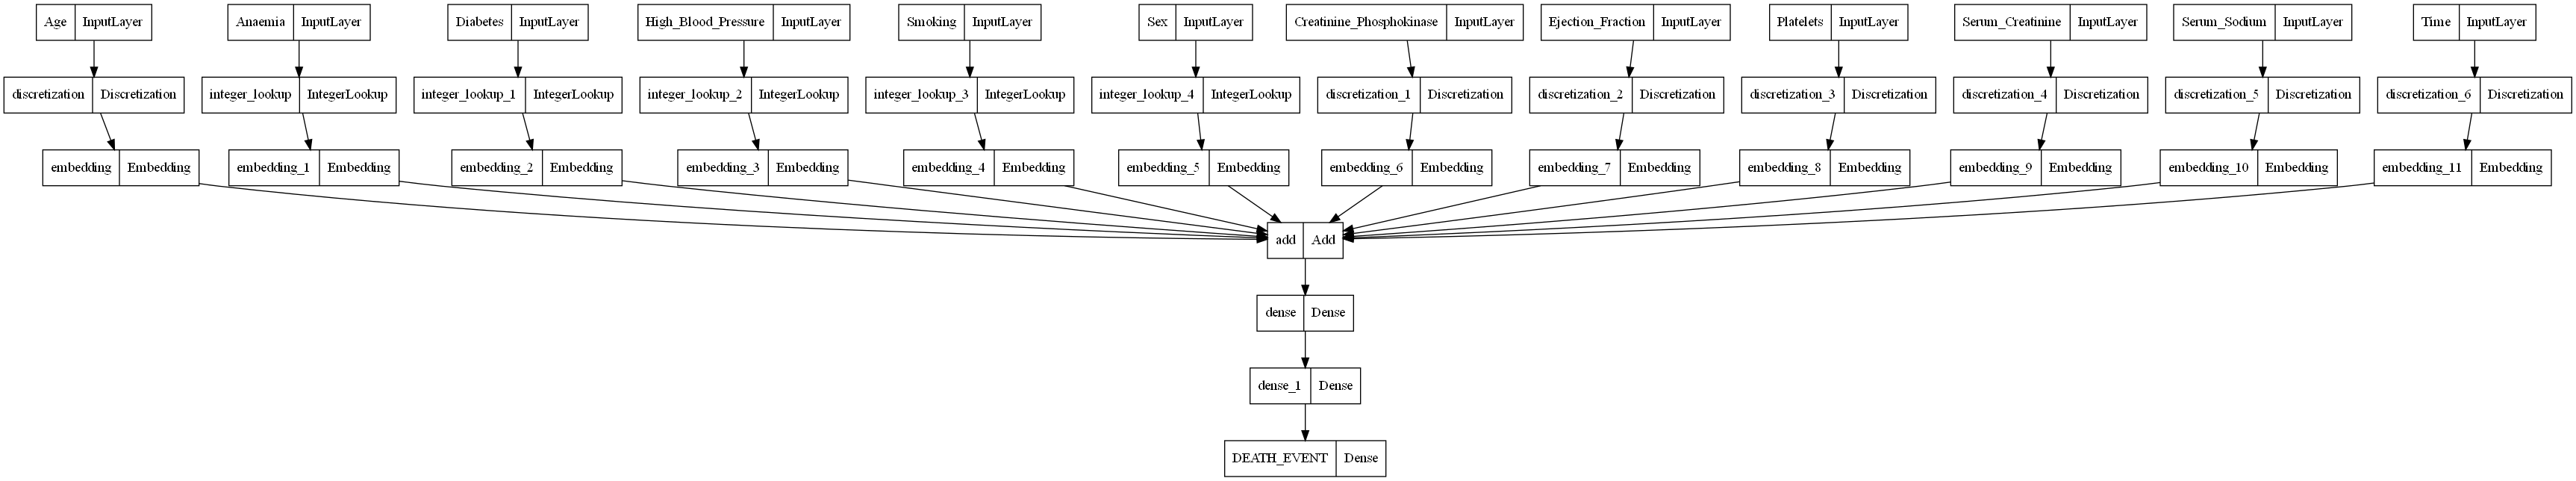

Functional API
--------------------------------------------------
Train Accuracy: 0.8827
Validation Accuracy: 0.8500
Test Accuracy: 0.8500
Test Loss: 5.4065
Test Recall: 0.5625
Test Precision: 0.8182


In [51]:
set_random_seed(1987)

# Define min and max values for each feature
min_max_values = {
    'age': (stats_df.loc['age', 'min'], stats_df.loc['age', 'max']),
    'creatinine_phosphokinase': (stats_df.loc['creatinine_phosphokinase', 'min'], stats_df.loc['creatinine_phosphokinase', 'max']),
    'ejection_fraction': (stats_df.loc['ejection_fraction', 'min'], stats_df.loc['ejection_fraction', 'max']),
    'platelets': (stats_df.loc['platelets', 'min'], stats_df.loc['platelets', 'max']),
    'serum_creatinine': (stats_df.loc['serum_creatinine', 'min'], stats_df.loc['serum_creatinine', 'max']),
    'serum_sodium': (stats_df.loc['serum_sodium', 'min'], stats_df.loc['serum_sodium', 'max']),
    'time': (stats_df.loc['time', 'min'], stats_df.loc['time', 'max']),
}

# Define step sizes
steps = {
    'age': 10,
    'creatinine_phosphokinase': 10,
    'ejection_fraction': 10,
    'platelets': 10,
    'serum_creatinine': 10,
    'serum_sodium': 10,
    'time': 10,
}

# Build Model
api_model = build_fun_api_model(min_max_values=min_max_values, steps=steps, embed_dim=1000, learning_rate=0.00008)
display(tf.keras.utils.plot_model(api_model))

fun_api_train_inputs={
    'Age': X_train[['age']],
    'Anaemia': X_train[['anaemia']],
    'Diabetes': X_train[['diabetes']],
    'High_Blood_Pressure': X_train[['high_blood_pressure']],
    'Smoking': X_train[['smoking']],
    'Sex': X_train[['sex']],
    'Creatinine_Phosphokinase': X_train[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_train[['ejection_fraction']],
    'Platelets': X_train[['platelets']],
    'Serum_Creatinine': X_train[['serum_creatinine']],
    'Serum_Sodium': X_train[['serum_sodium']],
    'Time': X_train[['time']],
    }

fun_api_validation_inputs={
    'Age': X_val[['age']],
    'Anaemia': X_val[['anaemia']],
    'Diabetes': X_val[['diabetes']],
    'High_Blood_Pressure': X_val[['high_blood_pressure']],
    'Smoking': X_val[['smoking']],
    'Sex': X_val[['sex']],
    'Creatinine_Phosphokinase': X_val[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_val[['ejection_fraction']],
    'Platelets': X_val[['platelets']],
    'Serum_Creatinine': X_val[['serum_creatinine']],
    'Serum_Sodium': X_val[['serum_sodium']],
    'Time': X_val[['time']],
    }

fun_api_test_inputs={
    'Age': X_test[['age']],
    'Anaemia': X_test[['anaemia']],
    'Diabetes': X_test[['diabetes']],
    'High_Blood_Pressure': X_test[['high_blood_pressure']],
    'Smoking': X_test[['smoking']],
    'Sex': X_test[['sex']],
    'Creatinine_Phosphokinase': X_test[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_test[['ejection_fraction']],
    'Platelets': X_test[['platelets']],
    'Serum_Creatinine': X_test[['serum_creatinine']],
    'Serum_Sodium': X_test[['serum_sodium']],
    'Time': X_test[['time']],
    }


history = api_model.fit(x=fun_api_train_inputs,y=pd.DataFrame(y_train), epochs=40, batch_size=32,
                        validation_data=(fun_api_validation_inputs,pd.DataFrame(y_val)), verbose=0)

#Define model predictions
api_train_pred = (api_model.predict(x=fun_api_train_inputs, verbose = 0) > 0.5).astype(int).flatten()
api_val_pred = (api_model.predict(x=fun_api_validation_inputs, verbose = 0) > 0.5).astype(int).flatten()
api_test_pred = (api_model.predict(x=fun_api_test_inputs, verbose = 0) > 0.5).astype(int).flatten()
api_results = [log_loss(y_test, api_test_pred), accuracy_score(y_test, api_test_pred)]
api_precision = precision_score(y_test, api_test_pred)
api_recall = recall_score(y_test, api_test_pred)
api_train_acc = accuracy_score(y_train, api_train_pred)
api_val_acc = accuracy_score(y_val, api_val_pred)

#Print results
api_results = print_results(api_train_acc, api_val_acc, api_recall, api_precision,model_name = "Functional API", acc_loss = api_results)


Text(0.5, 1.0, 'Functional API Test Confusion Matrix')

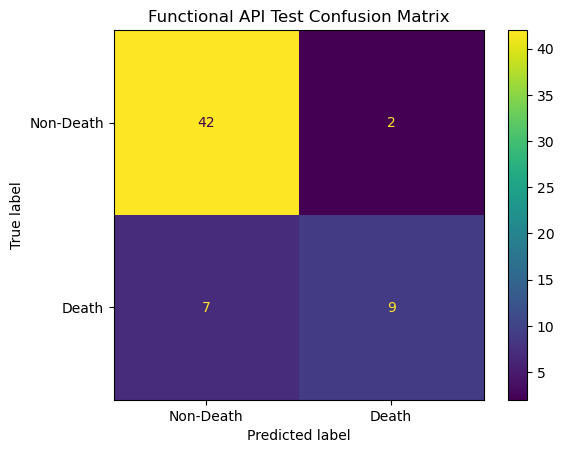

In [52]:
#Plot confusion matrix
cm = confusion_matrix(y_test, api_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Functional API Test Confusion Matrix")

### Augmented

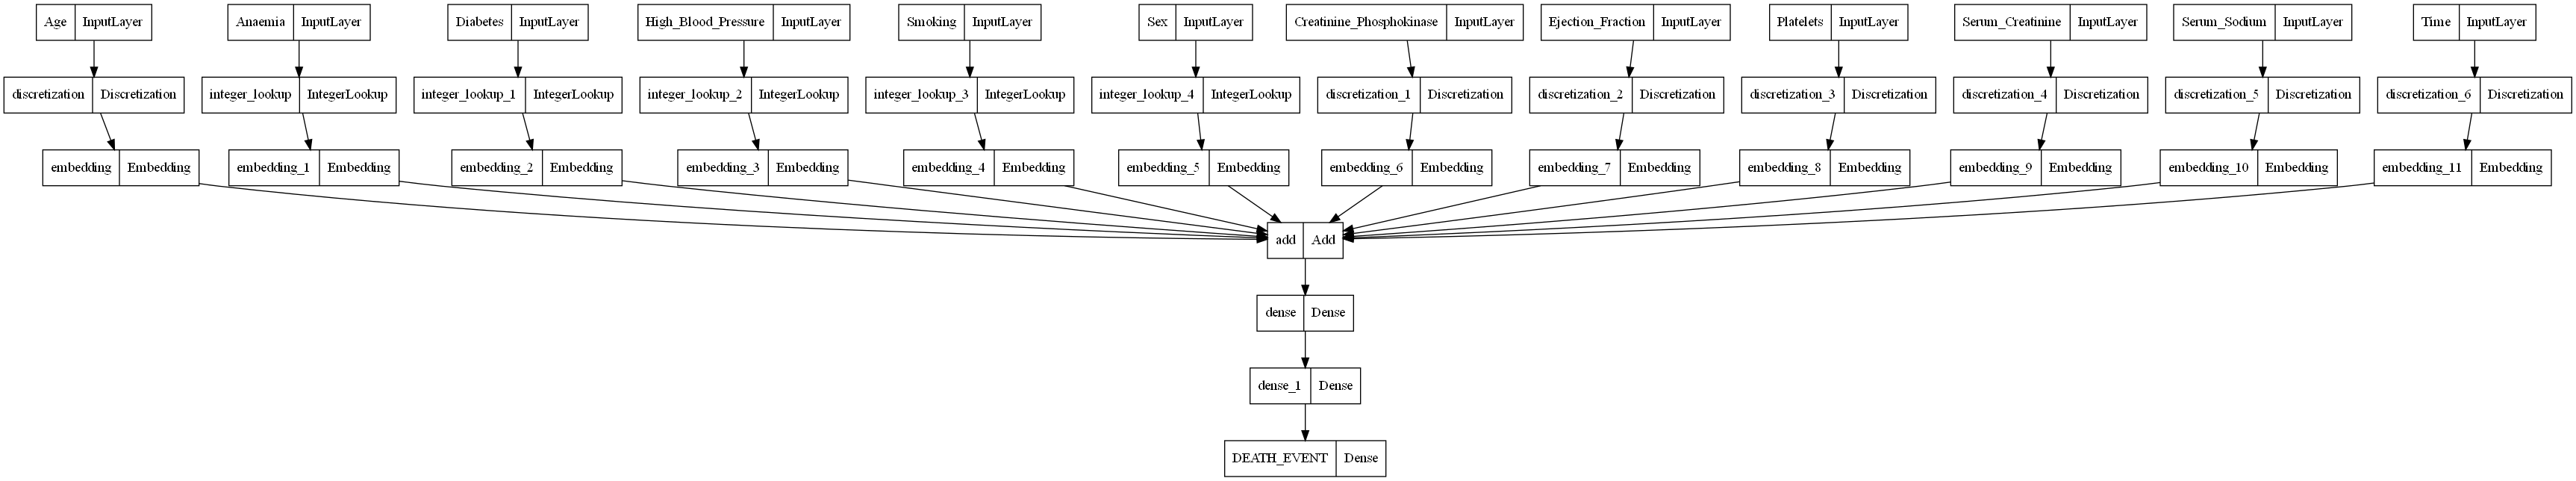

Functional API
--------------------------------------------------
Train Accuracy: 0.8390
Validation Accuracy: 0.8500
Test Accuracy: 0.8333
Test Loss: 6.0073
Test Recall: 0.7500
Test Precision: 0.6667


In [53]:
set_random_seed(2000)


# Define min and max values for each feature
min_max_values = {
    'age': (stats_df.loc['age', 'min'], stats_df.loc['age', 'max']),
    'creatinine_phosphokinase': (stats_df.loc['creatinine_phosphokinase', 'min'], stats_df.loc['creatinine_phosphokinase', 'max']),
    'ejection_fraction': (stats_df.loc['ejection_fraction', 'min'], stats_df.loc['ejection_fraction', 'max']),
    'platelets': (stats_df.loc['platelets', 'min'], stats_df.loc['platelets', 'max']),
    'serum_creatinine': (stats_df.loc['serum_creatinine', 'min'], stats_df.loc['serum_creatinine', 'max']),
    'serum_sodium': (stats_df.loc['serum_sodium', 'min'], stats_df.loc['serum_sodium', 'max']),
    'time': (stats_df.loc['time', 'min'], stats_df.loc['time', 'max']),
}

# Define step sizes
steps = {
    'age': 10,
    'creatinine_phosphokinase': 10,
    'ejection_fraction': 10,
    'platelets': 10,
    'serum_creatinine': 10,
    'serum_sodium': 10,
    'time': 10,
}

aug_api_model = build_fun_api_model(min_max_values=min_max_values, steps=steps, embed_dim=1000, learning_rate=0.00008)
display(tf.keras.utils.plot_model(aug_api_model))

fun_api_aug_train_inputs={
    'Age': X_aug[['age']],
    'Anaemia': X_aug[['anaemia']],
    'Diabetes': X_aug[['diabetes']],
    'High_Blood_Pressure': X_aug[['high_blood_pressure']],
    'Smoking': X_aug[['smoking']],
    'Sex': X_aug[['sex']],
    'Creatinine_Phosphokinase': X_aug[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_aug[['ejection_fraction']],
    'Platelets': X_aug[['platelets']],
    'Serum_Creatinine': X_aug[['serum_creatinine']],
    'Serum_Sodium': X_aug[['serum_sodium']],
    'Time': X_aug[['time']],
    }

fun_api_validation_inputs={
    'Age': X_val[['age']],
    'Anaemia': X_val[['anaemia']],
    'Diabetes': X_val[['diabetes']],
    'High_Blood_Pressure': X_val[['high_blood_pressure']],
    'Smoking': X_val[['smoking']],
    'Sex': X_val[['sex']],
    'Creatinine_Phosphokinase': X_val[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_val[['ejection_fraction']],
    'Platelets': X_val[['platelets']],
    'Serum_Creatinine': X_val[['serum_creatinine']],
    'Serum_Sodium': X_val[['serum_sodium']],
    'Time': X_val[['time']],
    }

fun_api_test_inputs={
    'Age': X_test[['age']],
    'Anaemia': X_test[['anaemia']],
    'Diabetes': X_test[['diabetes']],
    'High_Blood_Pressure': X_test[['high_blood_pressure']],
    'Smoking': X_test[['smoking']],
    'Sex': X_test[['sex']],
    'Creatinine_Phosphokinase': X_test[['creatinine_phosphokinase']],
    'Ejection_Fraction': X_test[['ejection_fraction']],
    'Platelets': X_test[['platelets']],
    'Serum_Creatinine': X_test[['serum_creatinine']],
    'Serum_Sodium': X_test[['serum_sodium']],
    'Time': X_test[['time']],
    }


history = aug_api_model.fit(x=fun_api_aug_train_inputs,y=pd.DataFrame(y_aug), epochs=40, batch_size=32,
                        validation_data=(fun_api_validation_inputs,pd.DataFrame(y_val)), verbose=0)

#Define model predictions
aug_api_train_pred = (aug_api_model.predict(x=fun_api_aug_train_inputs, verbose = 0) > 0.5).astype(int).flatten()
aug_api_val_pred = (aug_api_model.predict(x=fun_api_validation_inputs, verbose = 0) > 0.5).astype(int).flatten()
aug_api_test_pred = (aug_api_model.predict(x=fun_api_test_inputs, verbose = 0) > 0.5).astype(int).flatten()
aug_api_results = [log_loss(y_test, aug_api_test_pred), accuracy_score(y_test, aug_api_test_pred)]
aug_api_precision = precision_score(y_test, aug_api_test_pred)
aug_api_recall = recall_score(y_test, aug_api_test_pred)
aug_api_train_acc = accuracy_score(y_aug, aug_api_train_pred)
aug_api_val_acc = accuracy_score(y_val, aug_api_val_pred)

#Print results
aug_api_results = print_results(aug_api_train_acc, aug_api_val_acc, aug_api_recall, aug_api_precision,model_name = "Functional API", acc_loss = aug_api_results)

Text(0.5, 1.0, 'Augmented Functional API Test Confusion Matrix')

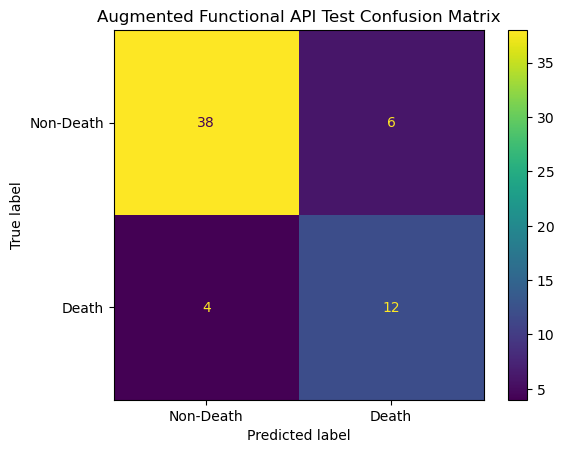

In [54]:
#Plot confusion matrix
cm = confusion_matrix(y_test, aug_api_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Functional API Test Confusion Matrix")

Text(0, 0.5, 'Recall')

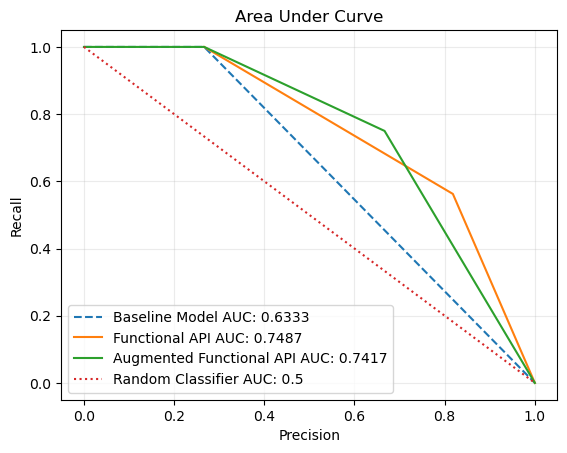

In [55]:
#Calculate precisions and recalls
aug_api_precisions, aug_api_recalls, thresholds = precision_recall_curve(y_test, aug_api_test_pred)
api_precisions, api_recalls, thresholds = precision_recall_curve(y_test, api_test_pred)
base_precisions, base_recalls, thresholds = precision_recall_curve(y_test, test_baseline_pred)

#Add 0 values
base_precisions = np.insert(base_precisions, 0,0)
base_recalls = np.insert(base_recalls, 0,1)

ada_precisions= np.insert(api_precisions, 0,0)
ada_recalls = np.insert(api_recalls, 0,1)

aug_api_precisions= np.insert(aug_api_precisions, 0,0)
aug_api_recalls = np.insert(aug_api_recalls, 0,1)

#Plot models
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(api_precisions, api_recalls, label = f"Functional API AUC: {round(auc(api_recalls, api_precisions), 4)}")
plt.plot(aug_api_precisions, aug_api_recalls, label = f"Augmented Functional API AUC: {round(auc(aug_api_recalls, aug_api_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

## KNN Classifier

### Non-Augmented

In [56]:
# Define KNN model
def build_knn(n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    return model

# Fit and evaluate model
knn_model = build_knn(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Calculate accuracies
knn_train_acc = knn_model.score(X_train, y_train)
knn_val_acc = knn_model.score(X_val, y_val)
knn_test_acc = knn_model.score(X_test, y_test)

# Predictions and metrics for test set
knn_test_pred = knn_model.predict(X_test)
knn_test_prob = knn_model.predict_proba(X_test)[:, 1]  # Probabilities for log loss calculation
knn_precision = precision_score(y_test, knn_test_pred)
knn_recall = recall_score(y_test, knn_test_pred)
knn_results = [log_loss(y_test, knn_model.predict_proba(X_test)), accuracy_score(y_test,knn_test_pred)]

# Print results
knn_results = print_results(knn_train_acc, knn_val_acc, knn_recall, knn_precision,model_name = "KNN Classifier", acc_loss = knn_results)


KNN Classifier
--------------------------------------------------
Train Accuracy: 0.8324
Validation Accuracy: 0.7833
Test Accuracy: 0.8000
Test Loss: 0.9875
Test Recall: 0.4375
Test Precision: 0.7000


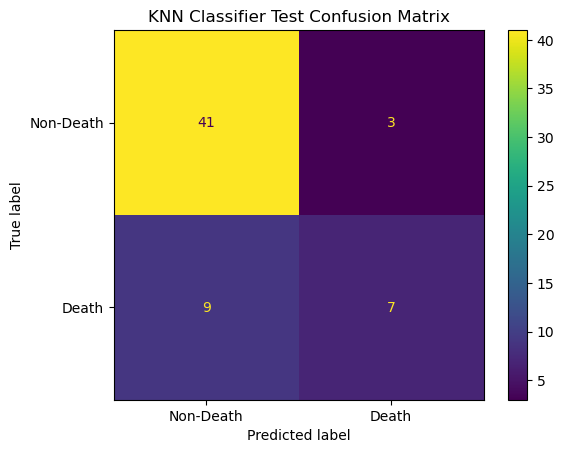

In [57]:
# Plot confusion matrix
cm = confusion_matrix(y_test, knn_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("KNN Classifier Test Confusion Matrix")
plt.show()

### Augmented

In [58]:
# Train and evaluate on augmented dataset
aug_knn_model = build_knn(n_neighbors=5)
aug_knn_model.fit(X_aug, y_aug)

# Calculate accuracies
aug_knn_train_acc = aug_knn_model.score(X_aug, y_aug)
aug_knn_val_acc = aug_knn_model.score(X_val, y_val)
aug_knn_test_acc = aug_knn_model.score(X_test, y_test)

# Predictions and metrics for augmented test set
aug_knn_test_pred = aug_knn_model.predict(X_test)
aug_knn_test_prob = aug_knn_model.predict_proba(X_test)[:, 1]  # Probabilities for log loss calculation
aug_knn_precision = precision_score(y_test, aug_knn_test_pred)
aug_knn_recall = recall_score(y_test, aug_knn_test_pred)
aug_knn_results = [log_loss(y_test, aug_knn_model.predict_proba(X_test)), accuracy_score(y_test,aug_knn_test_pred)]

# Print results
aug_knn_results = print_results(aug_knn_train_acc, aug_knn_val_acc, aug_knn_recall, aug_knn_precision,model_name = "Augmented KNN Classifier", acc_loss = aug_knn_results)


Augmented KNN Classifier
--------------------------------------------------
Train Accuracy: 0.8378
Validation Accuracy: 0.8500
Test Accuracy: 0.7667
Test Loss: 0.4190
Test Recall: 0.3750
Test Precision: 0.6000


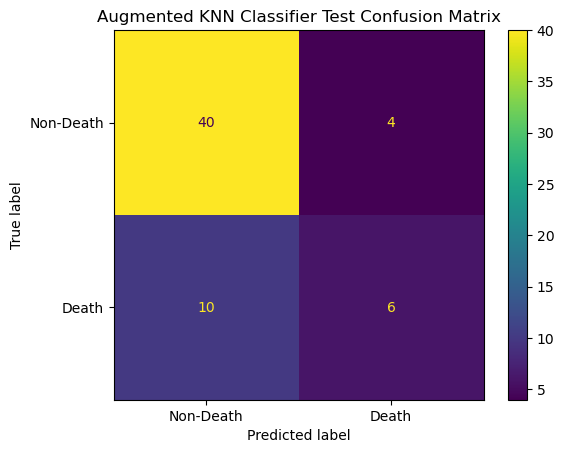

In [59]:
# Plot confusion matrix for augmented KNN
cm = confusion_matrix(y_test, aug_knn_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("Augmented KNN Classifier Test Confusion Matrix")
plt.show()

### Comparison AUC

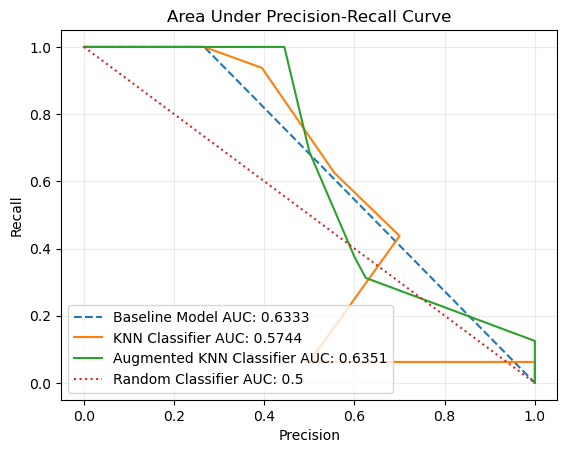

In [60]:
# Calculate precision-recall curves
base_precisions, base_recalls, _ = precision_recall_curve(y_test, test_baseline_pred)
knn_precisions, knn_recalls, _ = precision_recall_curve(y_test, knn_test_prob)
aug_knn_precisions, aug_knn_recalls, _ = precision_recall_curve(y_test, aug_knn_test_prob)

# Add 0 values for plot consistency
base_precisions = np.insert(base_precisions, 0, 0)
base_recalls = np.insert(base_recalls, 0, 1)

knn_precisions = np.insert(knn_precisions, 0, 0)
knn_recalls = np.insert(knn_recalls, 0, 1)

aug_knn_precisions = np.insert(aug_knn_precisions, 0, 0)
aug_knn_recalls = np.insert(aug_knn_recalls, 0, 1)

# Plot Precision-Recall Curve
plt.plot(base_precisions, base_recalls, label=f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle='dashed')
plt.plot(knn_precisions, knn_recalls, label=f"KNN Classifier AUC: {round(auc(knn_recalls, knn_precisions), 4)}")
plt.plot(aug_knn_precisions, aug_knn_recalls, label=f"Augmented KNN Classifier AUC: {round(auc(aug_knn_recalls, aug_knn_precisions), 4)}")
plt.plot([0, 1], [1, 0], linestyle='dotted', label=f"Random Classifier AUC: {0.5}")

# Add formatting
plt.legend()
plt.grid(True, alpha=0.25)
plt.title("Area Under Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

## Voting Classifier

### Non-Augmented

In [61]:
# Define models for voting
logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier()

# Build majority vote model
voting_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('knn', knn),
    ('dtree', dtree)
], voting='soft')  # 'soft' for probability-based voting

# Train and evaluate majority vote model
voting_model.fit(X_train, y_train)

# Calculate accuracies
voting_train_acc = voting_model.score(X_train, y_train)
voting_val_acc = voting_model.score(X_val, y_val)
voting_test_acc = voting_model.score(X_test, y_test)

# Predictions and metrics for test set
voting_test_pred = voting_model.predict(X_test)
voting_test_prob = voting_model.predict_proba(X_test)[:, 1]  # Average probabilities for log loss and AUC
voting_precision = precision_score(y_test, voting_test_pred)
voting_recall = recall_score(y_test, voting_test_pred)
voting_results = [log_loss(y_test, voting_model.predict_proba(X_test)), accuracy_score(y_test,voting_test_pred)]

voting_results = print_results(voting_train_acc, voting_val_acc, voting_recall, voting_precision,model_name = "Voting Classifier", acc_loss = voting_results)


Voting Classifier
--------------------------------------------------
Train Accuracy: 0.9609
Validation Accuracy: 0.7667
Test Accuracy: 0.7833
Test Loss: 0.4027
Test Recall: 0.4375
Test Precision: 0.6364


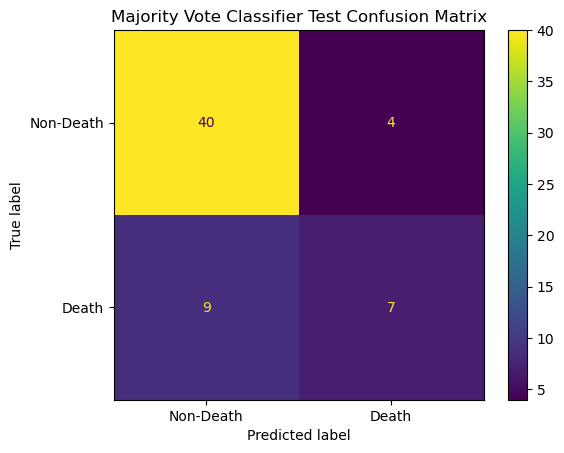

In [62]:
# Plot confusion matrix
cm = confusion_matrix(y_test, voting_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("Majority Vote Classifier Test Confusion Matrix")
plt.show()

### Augmented

In [63]:
# Train and evaluate on augmented dataset
aug_voting_model = VotingClassifier(estimators=[
    ('logreg', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dtree', DecisionTreeClassifier())
], voting='soft')

aug_voting_model.fit(X_aug, y_aug)

# Calculate accuracies
aug_voting_train_acc = aug_voting_model.score(X_aug, y_aug)
aug_voting_val_acc = aug_voting_model.score(X_val, y_val)
aug_voting_test_acc = aug_voting_model.score(X_test, y_test)

# Predictions and metrics for augmented test set
aug_voting_test_pred = aug_voting_model.predict(X_test)
aug_voting_test_prob = aug_voting_model.predict_proba(X_test)[:, 1]
aug_voting_precision = precision_score(y_test, aug_voting_test_pred)
aug_voting_recall = recall_score(y_test, aug_voting_test_pred)
aug_voting_results = [log_loss(y_test, aug_voting_model.predict_proba(X_test)), accuracy_score(y_test,aug_voting_test_pred)]

aug_voting_results = print_results(aug_voting_train_acc, aug_voting_val_acc, aug_voting_recall, aug_voting_precision,model_name = "Augmented Voting Classifier", acc_loss = aug_voting_results)


Augmented Voting Classifier
--------------------------------------------------
Train Accuracy: 0.9660
Validation Accuracy: 0.8333
Test Accuracy: 0.8500
Test Loss: 0.3333
Test Recall: 0.7500
Test Precision: 0.7059


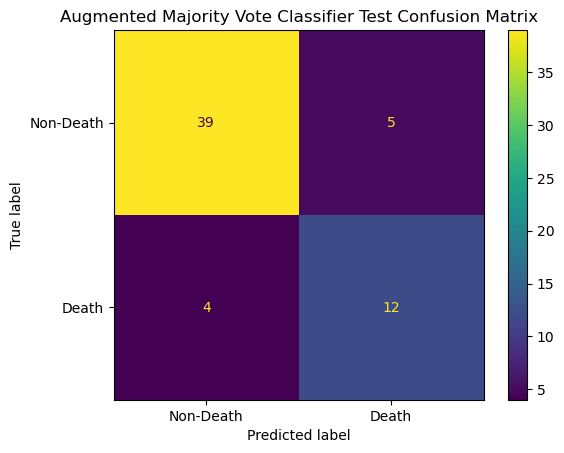

In [64]:
# Plot confusion matrix for augmented model
cm = confusion_matrix(y_test, aug_voting_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("Augmented Majority Vote Classifier Test Confusion Matrix")
plt.show()


### Comparison AUC

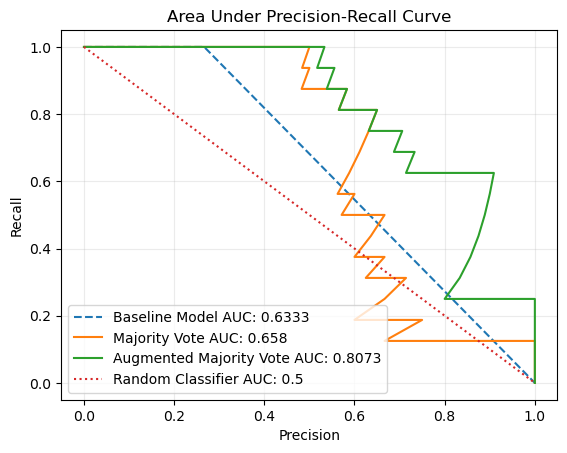

In [65]:
# Calculate precision-recall curves
base_precisions, base_recalls, _ = precision_recall_curve(y_test, test_baseline_pred)
voting_precisions, voting_recalls, _ = precision_recall_curve(y_test, voting_test_prob)
aug_voting_precisions, aug_voting_recalls, _ = precision_recall_curve(y_test, aug_voting_test_prob)

# Add 0 values for plot consistency
base_precisions = np.insert(base_precisions, 0, 0)
base_recalls = np.insert(base_recalls, 0, 1)

voting_precisions = np.insert(voting_precisions, 0, 0)
voting_recalls = np.insert(voting_recalls, 0, 1)

aug_voting_precisions = np.insert(aug_voting_precisions, 0, 0)
aug_voting_recalls = np.insert(aug_voting_recalls, 0, 1)

# Plot Precision-Recall Curve
plt.plot(base_precisions, base_recalls, label=f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle='dashed')
plt.plot(voting_precisions, voting_recalls, label=f"Majority Vote AUC: {round(auc(voting_recalls, voting_precisions), 4)}")
plt.plot(aug_voting_precisions, aug_voting_recalls, label=f"Augmented Majority Vote AUC: {round(auc(aug_voting_recalls, aug_voting_precisions), 4)}")
plt.plot([0, 1], [1, 0], linestyle='dotted', label=f"Random Classifier AUC: {0.5}")

# Add formatting
plt.legend()
plt.grid(True, alpha=0.25)
plt.title("Area Under Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

## Bagging Classifier

### Non-Augmented

In [66]:
# Define Bagging model
base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42)

# Train and evaluate Bagging model
bagging_model.fit(X_train, y_train)

# Calculate accuracies
bagging_train_acc = bagging_model.score(X_train, y_train)
bagging_val_acc = bagging_model.score(X_val, y_val)
bagging_test_acc = bagging_model.score(X_test, y_test)

# Predictions and metrics for test set
bagging_test_pred = bagging_model.predict(X_test)
bagging_test_prob = np.mean([est.predict_proba(X_test)[:, 1] for est in bagging_model.estimators_], axis=0)
bagging_precision = precision_score(y_test, bagging_test_pred)
bagging_recall = recall_score(y_test, bagging_test_pred)
bagging_results = [log_loss(y_test, bagging_model.predict_proba(X_test)), accuracy_score(y_test,bagging_test_pred)]

# Print results
bagging_results = print_results(bagging_train_acc, bagging_val_acc, bagging_recall, bagging_precision,model_name = "Bagging Classifier", acc_loss = bagging_results)


Bagging Classifier
--------------------------------------------------
Train Accuracy: 0.9832
Validation Accuracy: 0.8333
Test Accuracy: 0.8000
Test Loss: 0.9265
Test Recall: 0.5000
Test Precision: 0.6667


c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier 

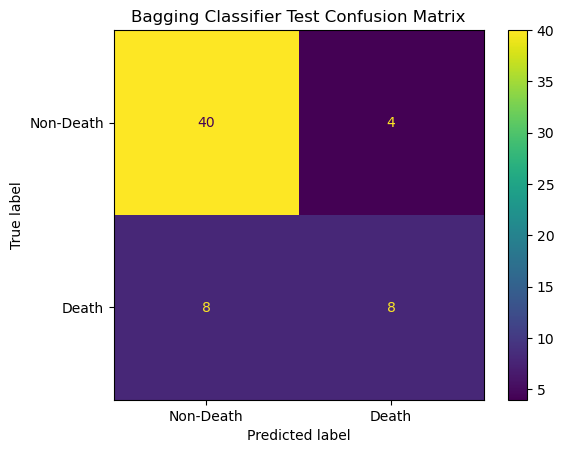

In [67]:
# Plot confusion matrix
cm = confusion_matrix(y_test, bagging_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("Bagging Classifier Test Confusion Matrix")
plt.show()

### Augmented

In [68]:
# Train and evaluate on augmented dataset
aug_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
aug_bagging_model.fit(X_aug, y_aug)

# Calculate accuracies
aug_bagging_train_acc = aug_bagging_model.score(X_aug, y_aug)
aug_bagging_val_acc = aug_bagging_model.score(X_val, y_val)
aug_bagging_test_acc = aug_bagging_model.score(X_test, y_test)

# Predictions and metrics for augmented test set
aug_bagging_test_pred = aug_bagging_model.predict(X_test)
aug_bagging_test_prob = np.mean([est.predict_proba(X_test)[:, 1] for est in aug_bagging_model.estimators_], axis=0)
aug_bagging_precision = precision_score(y_test, aug_bagging_test_pred)
aug_bagging_recall = recall_score(y_test, aug_bagging_test_pred)
aug_bagging_results = [log_loss(y_test, aug_bagging_model.predict_proba(X_test)), accuracy_score(y_test, aug_bagging_test_pred)]

# Print results
aug_bagging_results = print_results(aug_bagging_train_acc, aug_bagging_val_acc, aug_bagging_recall, aug_bagging_precision,model_name = "Bagging Classifier", acc_loss = aug_bagging_results)


Bagging Classifier
--------------------------------------------------
Train Accuracy: 0.9830
Validation Accuracy: 0.8833
Test Accuracy: 0.8667
Test Loss: 0.8841
Test Recall: 0.6250
Test Precision: 0.8333


c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kentb\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier 

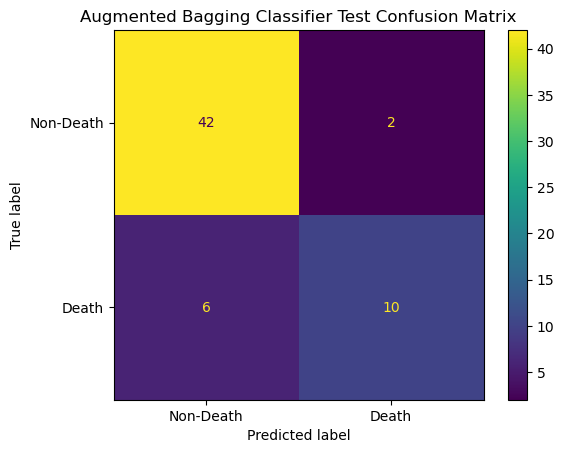

In [69]:
# Plot confusion matrix for augmented model
cm = confusion_matrix(y_test, aug_bagging_test_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Death", "Death"]).plot()
plt.title("Augmented Bagging Classifier Test Confusion Matrix")
plt.show()

### Comparison AUC

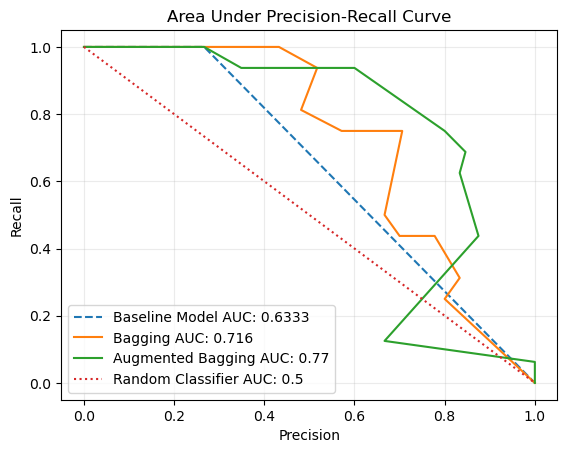

In [70]:
# Calculate precision-recall curves
base_precisions, base_recalls, _ = precision_recall_curve(y_test, test_baseline_pred)
bagging_precisions, bagging_recalls, _ = precision_recall_curve(y_test, bagging_test_prob)
aug_bagging_precisions, aug_bagging_recalls, _ = precision_recall_curve(y_test, aug_bagging_test_prob)

# Add 0 values for plot consistency
base_precisions = np.insert(base_precisions, 0, 0)
base_recalls = np.insert(base_recalls, 0, 1)

bagging_precisions = np.insert(bagging_precisions, 0, 0)
bagging_recalls = np.insert(bagging_recalls, 0, 1)

aug_bagging_precisions = np.insert(aug_bagging_precisions, 0, 0)
aug_bagging_recalls = np.insert(aug_bagging_recalls, 0, 1)

# Plot Precision-Recall Curve
plt.plot(base_precisions, base_recalls, label=f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle='dashed')
plt.plot(bagging_precisions, bagging_recalls, label=f"Bagging AUC: {round(auc(bagging_recalls, bagging_precisions), 4)}")
plt.plot(aug_bagging_precisions, aug_bagging_recalls, label=f"Augmented Bagging AUC: {round(auc(aug_bagging_recalls, aug_bagging_precisions), 4)}")
plt.plot([0, 1], [1, 0], linestyle='dotted', label=f"Random Classifier AUC: {0.5}")

# Add formatting
plt.legend()
plt.grid(True, alpha=0.25)
plt.title("Area Under Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

## Model Comparisons

In [71]:
#Define comparison metrics
metrics = ['Train Accuracy','Validation Accuracy', 'Test Accuracy', 'Test Loss', 'Test Recall', 'Test Precision']

#Model Names
model_names = ['Baseline', 'Logistic Regression', 'Augmented Logistic Regression', 'Sequential Neural Network', 'Augmented Sequential Neural Network',
               'Decision Tree', 'Augmented Decision Tree', 'Random Forest',
               'Augmented Random Forest', 'Gradient Boosting', 'Augmented Gradient Boosting', 'AdaBoost', 'Augmented AdaBoost',
               'Functional Neural Network', 'Augmented Functional Neural Network', 'KNN', 'Augmented KNN', 'Voting Classifier',
               'Augmented Voting Classifier', 'Bagging Classifier', 'Augmented Bagging Classifier']

In [72]:
#Concat model results
model_results = np.array([baseline_results, lr_results, aug_lr_results, ann_results, aug_ann_results, dt_results, aug_dt_results,
                 rf_results, aug_rf_results, gb_results, aug_gb_results, ada_results, aug_ada_results, api_results, aug_api_results,
                knn_results, aug_knn_results, voting_results, aug_voting_results, bagging_results, aug_bagging_results,])

#Define model results DataFrame
model_results_df = pd.DataFrame(model_results, columns = metrics)

#Add model names
model_results_df['Model'] = model_names

#Reorder columns
column_order = ['Model','Train Accuracy','Validation Accuracy', 'Test Accuracy', 'Test Loss', 'Test Recall', 'Test Precision']

model_results_df = model_results_df[column_order]

In [73]:
#Rank model results
model_results_df = model_results_df.sort_values(by = ['Test Loss'], ascending = [True])

model_results_df.index = model_results_df.reset_index(drop = True).index + 1

model_results_df

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Test Loss,Test Recall,Test Precision
1,Augmented Gradient Boosting,0.883568,0.883333,0.850000,0.274340,0.6250,0.769231
2,Augmented Logistic Regression,0.768681,0.833333,0.866667,0.333275,0.6250,0.833333
3,Augmented Voting Classifier,0.966017,0.833333,0.850000,0.333336,0.7500,0.705882
4,Augmented Decision Tree,0.778336,0.783333,0.800000,0.335736,0.4375,0.700000
5,Random Forest,0.960894,0.866667,0.866667,0.340767,0.6875,0.785714
6,Augmented Sequential Neural Network,0.809809,0.866667,0.850000,0.356491,0.5000,0.888889
7,Logistic Regression,0.837989,0.800000,0.816667,0.365997,0.5625,0.692308
8,Augmented Random Forest,0.793976,0.850000,0.816667,0.391763,0.4375,0.777778
9,Voting Classifier,0.960894,0.766667,0.783333,0.402737,0.4375,0.636364
10,Augmented KNN,0.837807,0.850000,0.766667,0.418960,0.3750,0.600000


Text(0, 0.5, 'Recall')

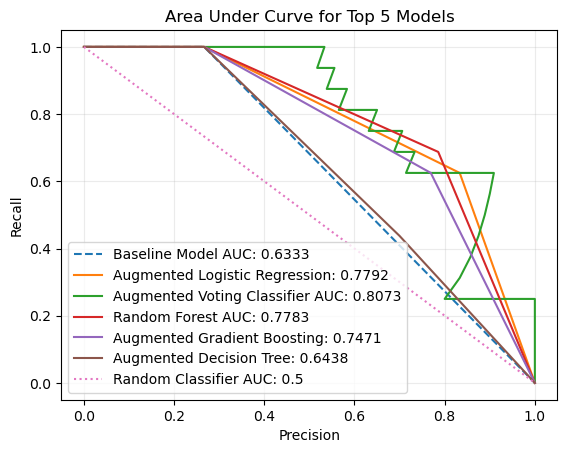

In [74]:
#Plot top 5 models  AUC
plt.plot(base_precisions, base_recalls, label = f"Baseline Model AUC: {round(auc(base_recalls, base_precisions), 4)}", linestyle = 'dashed')
plt.plot(aug_lr_precisions, aug_lr_recalls, label = f"Augmented Logistic Regression: {round(auc(aug_lr_recalls, aug_lr_precisions), 4)}")
plt.plot(aug_voting_precisions, aug_voting_recalls, label = f"Augmented Voting Classifier AUC: {round(auc(aug_voting_recalls, aug_voting_precisions), 4)}")
plt.plot(rf_precisions, rf_recalls, label = f"Random Forest AUC: {round(auc(rf_recalls, rf_precisions), 4)}")
plt.plot(aug_gb_precisions, aug_gb_recalls, label = f"Augmented Gradient Boosting: {round(auc(aug_gb_recalls, aug_gb_precisions), 4)}")
plt.plot(aug_dt_precisions, aug_dt_recalls, label = f"Augmented Decision Tree: {round(auc(aug_dt_recalls, aug_dt_precisions), 4)}")
plt.plot([0,1], [1,0], linestyle = 'dotted', label = f"Random Classifier AUC: {0.5}")

#Add formatting
plt.legend()
plt.grid(True, alpha = .25)
plt.title("Area Under Curve for Top 5 Models")
plt.xlabel("Precision")
plt.ylabel("Recall")

## Testing Decision Boundaries For Top Models

- Using the best ranked models from above we are interested in having the best Recall possible without sacrificing test accuracy and precision

### Augmented Gradient Boosting

In [75]:
# Augmented Gradient Boosting
new_aug_gb_test_pred = [1 if i > .25 else 0 for i in(aug_gb_model.predict_proba(X_test))[:,1]]
new_aug_gb_results = [log_loss(y_test, aug_gb_model.predict_proba(X_test)), accuracy_score(y_test,new_aug_gb_test_pred)]
new_aug_gb_precision = precision_score(y_test, new_aug_gb_test_pred)
new_aug_gb_recall = recall_score(y_test, new_aug_gb_test_pred)

print(f"Test Loss: {new_aug_gb_results[0]}\nTest Accuracy: {new_aug_gb_results[1]}\nTest Precision: {new_aug_gb_precision}\nTest Recall: {new_aug_gb_recall}")

Test Loss: 0.27434002872995045
Test Accuracy: 0.8833333333333333
Test Precision: 0.6956521739130435
Test Recall: 1.0


Text(0.5, 1.0, 'Augmented Gradient Boosting Test Confusion Matrix')

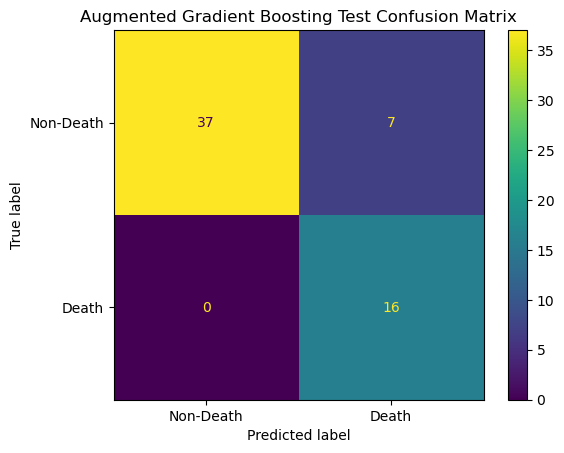

In [76]:
#Plot confusion matrix
cm = confusion_matrix(y_test, new_aug_gb_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Gradient Boosting Test Confusion Matrix")

### Augmented Voting Classifier

In [77]:
# Augmented Voting Classifier
new_aug_voting_test_pred = [1 if i > .25 else 0 for i in(aug_voting_model.predict_proba(X_test))[:,1]]
new_aug_voting_results = [log_loss(y_test, aug_voting_model.predict_proba(X_test)), accuracy_score(y_test,new_aug_voting_test_pred)]
new_aug_voting_precision = precision_score(y_test, new_aug_voting_test_pred)
new_aug_voting_recall = recall_score(y_test, new_aug_voting_test_pred)

print(f"Test Loss: {new_aug_voting_results[0]}\nTest Accuracy: {new_aug_voting_results[1]}\nTest Precision: {new_aug_voting_precision}\nTest Recall: {new_aug_voting_recall}")

Test Loss: 0.33333583974074404
Test Accuracy: 0.7833333333333333
Test Precision: 0.5652173913043478
Test Recall: 0.8125


Text(0.5, 1.0, 'Augmented Voting Classifier Test Confusion Matrix')

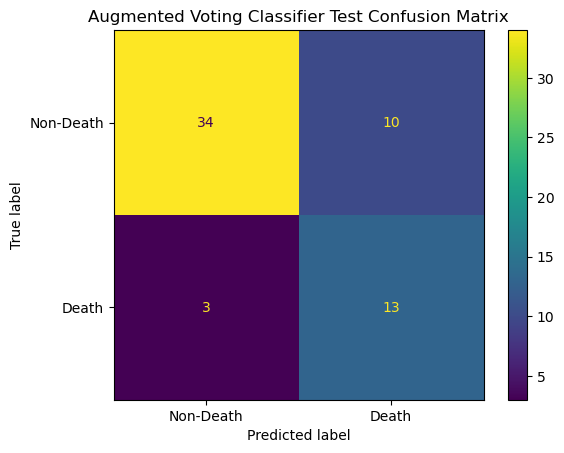

In [78]:
#Plot confusion matrix
cm = confusion_matrix(y_test, new_aug_voting_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Voting Classifier Test Confusion Matrix")

### Augmented Decision Tree

In [79]:
# Augmented Decision Tree
new_aug_dt_test_pred = [1 if i > .3 else 0 for i in(aug_dt_model.predict_proba(X_test))[:,1]]
new_aug_dt_results = [log_loss(y_test, aug_dt_model.predict_proba(X_test)), accuracy_score(y_test,new_aug_dt_test_pred)]
new_aug_dt_precision = precision_score(y_test, new_aug_dt_test_pred)
new_aug_dt_recall = recall_score(y_test, new_aug_dt_test_pred)

print(f"Test Loss: {new_aug_dt_results[0]}\nTest Accuracy: {new_aug_dt_results[1]}\nTest Precision: {new_aug_dt_precision}\nTest Recall: {new_aug_dt_recall}")

Test Loss: 0.3357357948165746
Test Accuracy: 0.85
Test Precision: 0.64
Test Recall: 1.0


Text(0.5, 1.0, 'Augmented Decision Tree Test Confusion Matrix')

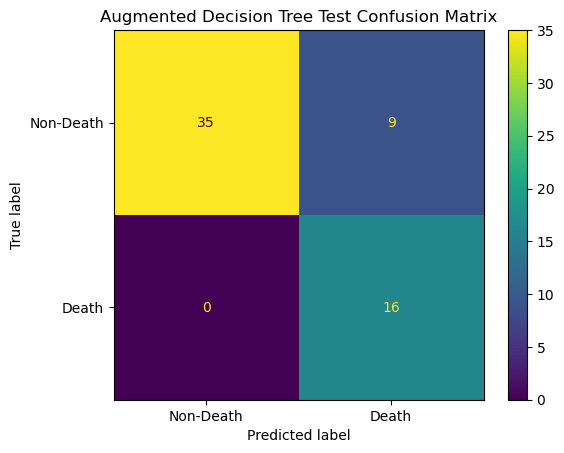

In [80]:
#Plot confusion matrix
cm = confusion_matrix(y_test, new_aug_dt_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Augmented Decision Tree Test Confusion Matrix")

### Augmented Random Forest

In [81]:
# Augmented Random Forest
new_rf_test_pred = [1 if i > .25 else 0 for i in(rf_model.predict_proba(X_test))[:,1]]
new_rf_results = [log_loss(y_test, rf_model.predict_proba(X_test)), accuracy_score(y_test,new_rf_test_pred)]
new_rf_precision = precision_score(y_test, new_rf_test_pred)
new_rf_recall = recall_score(y_test, new_rf_test_pred)

print(f"Test Loss: {new_rf_results[0]}\nTest Accuracy: {new_rf_results[1]}\nTest Precision: {new_rf_precision}\nTest Recall: {new_rf_recall}")

Test Loss: 0.34076666656784116
Test Accuracy: 0.8166666666666667
Test Precision: 0.6
Test Recall: 0.9375


Text(0.5, 1.0, 'Random Forest Test Confusion Matrix')

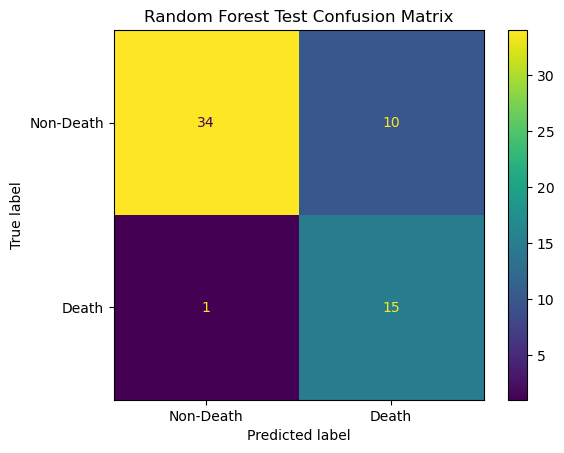

In [82]:
#Plot confusion matrix
cm = confusion_matrix(y_test, new_rf_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Random Forest Test Confusion Matrix")

### Augmented Logistic Regression

In [83]:
# Augmented Logistic Regression
new_aug_lr_test_pred = [1 if i > .35 else 0 for i in(aug_lr_model.predict(X_test))]
new_aug_lr_results = [log_loss(y_test, new_aug_lr_test_pred), accuracy_score(y_test,new_aug_lr_test_pred)]
new_aug_lr_precision = precision_score(y_test, new_aug_lr_test_pred)
new_aug_lr_recall = recall_score(y_test, new_aug_lr_test_pred)

print(f"Test Loss: {new_aug_lr_results[0]}\nTest Accuracy: {new_aug_lr_results[1]}\nTest Precision: {new_aug_lr_precision}\nTest Recall: {new_aug_lr_recall}")

2/2 [==============================] - 0s 14ms/step
Test Loss: 5.406548008367573
Test Accuracy: 0.85
Test Precision: 0.6842105263157895
Test Recall: 0.8125


Text(0.5, 1.0, 'Random Forest Test Confusion Matrix')

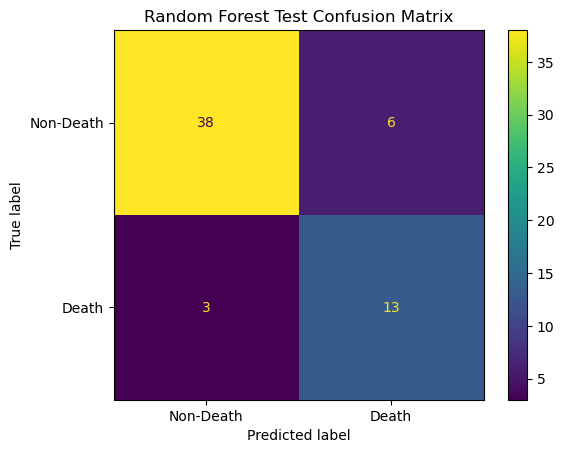

In [84]:
#Plot confusion matrix
cm = confusion_matrix(y_test, new_aug_lr_test_pred)

ConfusionMatrixDisplay(cm, display_labels = ["Non-Death", "Death"]).plot()

plt.title("Random Forest Test Confusion Matrix")

# Summary Statistics Results 

### Filter Model Results DF

In [ ]:
model_result_df_filtered = model_results_df.iloc[0:-1, :]
model_result_df_filtered

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Test Loss,Test Recall,Test Precision
1,Augmented Gradient Boosting,0.883568,0.883333,0.850000,0.274340,0.6250,0.769231
2,Augmented Logistic Regression,0.768681,0.833333,0.866667,0.333275,0.6250,0.833333
3,Augmented Voting Classifier,0.966017,0.833333,0.850000,0.333336,0.7500,0.705882
4,Augmented Decision Tree,0.778336,0.783333,0.800000,0.335736,0.4375,0.700000
5,Random Forest,0.960894,0.866667,0.866667,0.340767,0.6875,0.785714
6,Augmented Sequential Neural Network,0.809809,0.866667,0.850000,0.356491,0.5000,0.888889
7,Logistic Regression,0.837989,0.800000,0.816667,0.365997,0.5625,0.692308
8,Augmented Random Forest,0.793976,0.850000,0.816667,0.391763,0.4375,0.777778
9,Voting Classifier,0.960894,0.766667,0.783333,0.402737,0.4375,0.636364
10,Augmented KNN,0.837807,0.850000,0.766667,0.418960,0.3750,0.600000


### Calculate average and standard deviation for all models

In [ ]:
# Calculate average and standard deviation for all models
summary_stats = model_result_df_filtered.iloc[:, 1:].agg(["mean", "std"])
summary_stats = summary_stats.applymap(lambda x: round(x, 4))

summary_stats

,Train Accuracy,Validation Accuracy,Test Accuracy,Test Loss,Test Recall,Test Precision
mean,0.8885,0.8367,0.8242,1.3574,0.5625,0.7244
std,0.0766,0.0332,0.0317,2.0375,0.1092,0.0863


### Calculate mean and standard deviation for parametric and non-parametric models

In [ ]:
# Define parametric and non-parametric models
parametric_models = [
    "Augmented Logistic Regression",  "Logistic Regression",  "Sequential Neural Network",
    "Augmented Sequential Neural Network", "Functional Neural Network",
    "Augmented Functional Neural Network"
]

non_parametric_models = [
    "Augmented Decision Tree", "Voting Classifier", "Augmented KNN", "AdaBoost", 
    "Augmented AdaBoost", "Augmented Bagging Classifier", "Bagging Classifier", "KNN",
    "Decision Tree", "Augmented Gradient Boosting",  "Augmented Voting Classifier",
    "Random Forest", "Augmented Random Forest", "Gradient Boosting"
]

# Filter models
parametric_df = model_results_df[model_results_df["Model"].isin(parametric_models)]
non_parametric_df = model_results_df[model_results_df["Model"].isin(non_parametric_models)]

# Calculate mean and standard deviation for parametric models
parametric_stats = parametric_df.iloc[:, 1:].agg(["mean", "std"]).applymap(lambda x: round(x, 4))

# Calculate mean and standard deviation for non-parametric models
non_parametric_stats = non_parametric_df.iloc[:, 1:].agg(["mean", "std"]).applymap(lambda x: round(x, 4))

# Display the results
print("Parametric Models Statistics:")
print(parametric_stats)
print("\nNon-Parametric Models Statistics:")
print(non_parametric_stats)


Parametric Models Statistics:
      Train Accuracy  Validation Accuracy  Test Accuracy  Test Loss  \
mean          0.8526               0.8361         0.8333     2.2505   
std           0.0719               0.0245         0.0298     2.6970   

      Test Recall  Test Precision  
mean       0.6042          0.7479  
std        0.0854          0.1160  

Non-Parametric Models Statistics:
      Train Accuracy  Validation Accuracy  Test Accuracy  Test Loss  \
mean          0.9038               0.8369         0.8202     0.9746   
std           0.0758               0.0371         0.0328     1.6564   

      Test Recall  Test Precision  
mean       0.5446          0.7143  
std        0.1161          0.0731  


### Calculate mean and standard deviation for augmented and non-augmented models

In [ ]:
# Define augmented and non-augmented models
augmented_models = [
    "Augmented Logistic Regression", "Augmented Sequential Neural Network", "Augmented Functional Neural Network",
    "Augmented Decision Tree", "Augmented KNN", "Augmented AdaBoost", "Augmented Bagging Classifier",
    "Augmented Gradient Boosting", "Augmented Voting Classifier", "Augmented Random Forest"
]

non_augmented_models = [
    model for model in model_result_df_filtered["Model"] if model not in augmented_models
]

# Filter models
augmented_df = model_result_df_filtered[model_result_df_filtered["Model"].isin(augmented_models)]
non_augmented_df = model_result_df_filtered[model_result_df_filtered["Model"].isin(non_augmented_models)]

# Calculate mean and standard deviation for augmented models
augmented_stats = augmented_df.iloc[:, 1:].agg(["mean", "std"]).applymap(lambda x: round(x, 4))

# Calculate mean and standard deviation for non-augmented models
non_augmented_stats = non_augmented_df.iloc[:, 1:].agg(["mean", "std"]).applymap(lambda x: round(x, 4))

print("Augmented Models Statistics:")
print(augmented_stats)
print("\nNon-Augmented Models Statistics:")
print(non_augmented_stats)


Augmented Models Statistics:
      Train Accuracy  Validation Accuracy  Test Accuracy  Test Loss  \
mean          0.8523               0.8500         0.8333     0.9946   
std           0.0739               0.0294         0.0314     1.7706   

      Test Recall  Test Precision  
mean       0.5625          0.7575  
std        0.1318          0.0883  

Non-Augmented Models Statistics:
      Train Accuracy  Validation Accuracy  Test Accuracy  Test Loss  \
mean          0.9246               0.8233         0.8150     1.7202   
std           0.0634               0.0326         0.0309     2.3100   

      Test Recall  Test Precision  
mean       0.5625          0.6913  
std        0.0884          0.0741  


### Calculate the total average and standard deviation across all accuracy metrics

In [ ]:
# Calculate the total average and standard deviation across all accuracy metrics
accuracy_columns = ["Train Accuracy", "Validation Accuracy", "Test Accuracy"]
total_average = summary_stats[accuracy_columns].iloc[0,:].mean()
total_std = summary_stats[accuracy_columns].iloc[1,:].mean()
total_average = round(total_average, 4)
total_std = round(total_std, 4)


print(f"Total Average Accuracy: {total_average}")
print(f"Total Standard Deviation of Accuracy: {total_std}")


Total Average Accuracy: 0.8498
Total Standard Deviation of Accuracy: 0.0472
